# Notebook used  to experiment with different models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from sklearn.metrics import  mean_pinball_loss

In [ ]:
!python3 -m pip install tensorflow_addons

In [2]:
df = pd.read_csv("../traces/traces_persona.csv",parse_dates=[0])[:].reset_index()
diff = [df["reconsile_dates"][i] - df["reconsile_dates"][i-1] for i in range(1,len(df["reconsile_dates"]))]
diff_df = pd.DataFrame({"diff": diff, "sec": [x.total_seconds() for x in diff]}) 

endtrain  =  int(len(diff_df) * 0.8)
startTestIndex = endtrain
endtestIndex =  len(diff_df)-1

train_data = diff_df["sec"][:endtrain]
test_data = diff_df["sec"][endtrain:]

In [ ]:
df,diff_df


In [10]:
df.describe(),diff_df.describe()

(             index
 count  1001.000000
 mean    500.000000
 std     289.108111
 min       0.000000
 25%     250.000000
 50%     500.000000
 75%     750.000000
 max    1000.000000,
                             diff          sec
 count                       1000  1000.000000
 mean      0 days 00:00:05.204821     5.204821
 std    0 days 00:00:00.611235877     0.611236
 min       0 days 00:00:00.206000     0.206000
 25%       0 days 00:00:05.168750     5.168750
 50%       0 days 00:00:05.198000     5.198000
 75%       0 days 00:00:05.230000     5.230000
 max       0 days 00:00:21.442000    21.442000)

In [11]:
df_stationarityTest = adfuller(df['reconsile_dates'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.0


/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/models/.venvModels/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


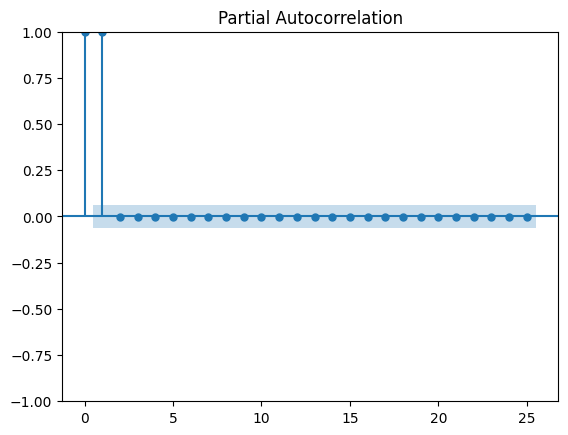

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['reconsile_dates'], lags=25)

# only use 2 long wide interval?

In [ ]:
plt.boxplot([diff_df["sec"]])

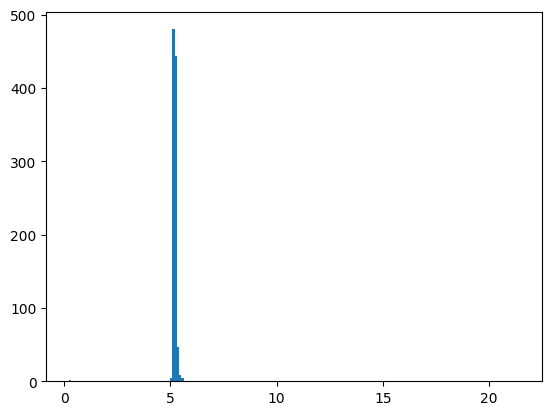

In [14]:
_ =  plt.hist(diff_df["sec"],bins=200)

# choosing loss function

In [3]:
# as defined in the scikit-learn  docs
# sklearn.metrics.mean_pinball_loss
def pinball_loss(y_true,y_pred, alpha=0.25):
    diff = y_true - y_pred
    sign = int(diff >= 0)
    loss = alpha * sign  * diff - (1 - alpha) * (1 - sign) * diff
    return loss

def total_perside_piball_loss(y_true_array,y_pred_array, alpha=0.25):
    assert len(y_pred_array) == len(y_true_array)
    underEstimate = []
    overEstimate = []
    totalEstimate = []
    for y_true,y_pred in zip(y_true_array,y_pred_array):

        diff = y_true - y_pred
        sign = int(diff >= 0)
        
        score = pinball_loss(y_true=y_true, y_pred=y_pred,alpha=alpha)
        
        if sign == 0:
            overEstimate.append(score)
        else:
            underEstimate.append(score)
        totalEstimate.append(score)
    
    underEstimate_score = np.mean(underEstimate)
    overEstimate_score = np.mean(overEstimate)
    ##print(totalEstimate)
    total_score = np.mean(totalEstimate)
    
    print(f"there are {len(underEstimate)} underEstimates with mean {underEstimate_score} ")
    print(f"there are {len(overEstimate)} overEstimates with mean {overEstimate_score}")
    print(f"total mean absolute pinball score {total_score}")
    return (underEstimate_score,overEstimate_score,total_score)

def plotDifferencepredictions(pred,testdata,startindex=None):
    #plt.rcParams["figure.figsize"] = (30, 10)


    
    pred = pd.DataFrame(pred)
    testdata = pd.DataFrame(testdata)

    if startindex is not None :
        pred.index = startindex
        testdata.index = startindex
    
        

    f, ax = plt.subplots() 
    f.set_figwidth(25)
    f.set_figheight(10)
    ax.plot(pred,'yo',label="prediction")
    ax.plot(testdata,'o', color='red',label="real")
    #plt.plot(pred,'yo',label="prediction")
    #plt.plot(testdata,'o', color='red',label="real")
    plt.legend(fontsize="xx-large")
    plt.show()





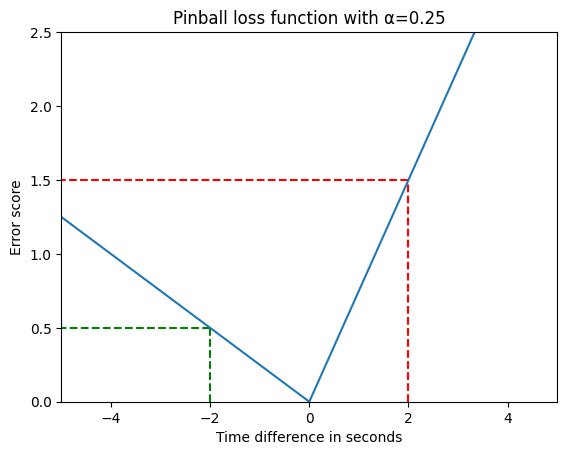

In [44]:
alpha = 0.25 
x = np.concatenate([np.arange(-5,0,0.1), np.arange(0,5.1,0.1)])
y = [pinball_loss(0,i,alpha) for  i in x]
plt.title("Pinball loss function with α=0.25")
plt.ylabel("Error score")
plt.xlabel("Time difference in seconds")
plt.vlines(x=-2, ymin=0, ymax=0.5, colors='green',linestyles='dashed')
plt.hlines(y=0.5, xmin=-2, xmax=-5, colors='green',linestyles='dashed')

plt.vlines(x=2, ymin=0, ymax=1.5, colors='r',linestyles='dashed')
plt.hlines(y=1.5, xmin=2, xmax=-5, colors='r',linestyles='dashed')

plt.ylim(0,2.5)
plt.xlim(-5,5)

plt.plot(x,y)


## auto regression

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

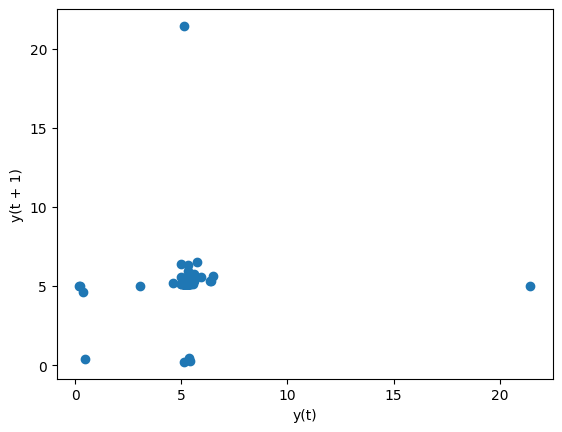

In [20]:
lag_plot(diff_df["sec"])

not really a lot of corrolation, no real line  visable

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

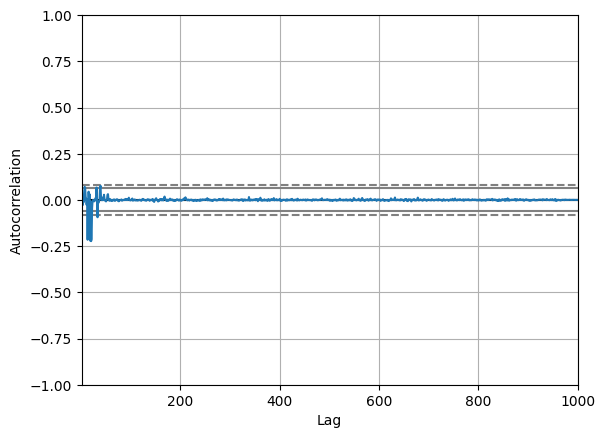

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff_df["sec"])

as expected, since the times are constant, no real big  swings, by adding more lag, we don't gain anything 

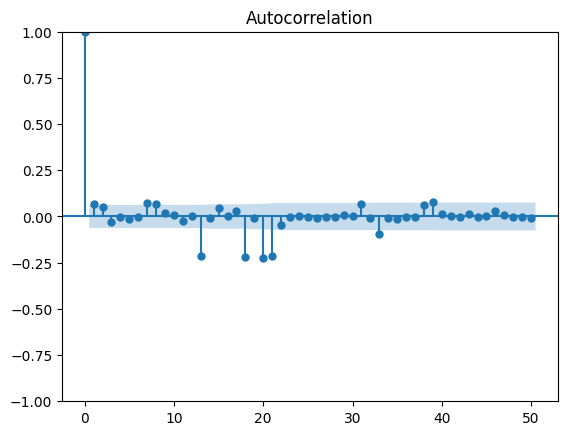

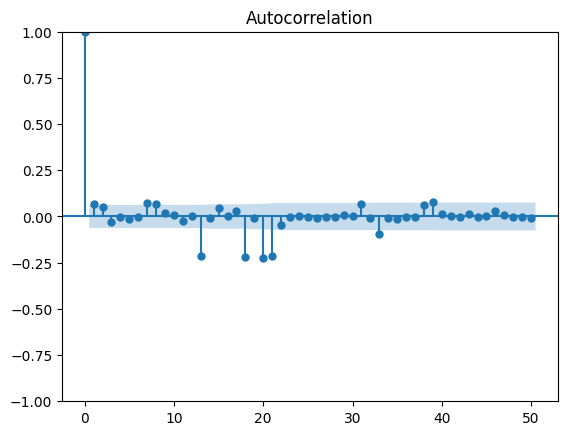

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff_df["sec"], lags=50)

after 25 we see only small differences

In [23]:
model = AutoReg(train_data, lags=10).fit()
print(model.summary())
pred = model.predict(start=startTestIndex, end=endtestIndex, dynamic=False)


                            AutoReg Model Results                             
Dep. Variable:                    sec   No. Observations:                  800
Model:                    AutoReg(10)   Log Likelihood                -812.571
Method:               Conditional MLE   S.D. of innovations              0.677
Date:                Mon, 20 Mar 2023   AIC                           1649.141
Time:                        12:27:56   BIC                           1705.205
Sample:                            10   HQIC                          1670.691
                                  800                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2236      0.527      8.013      0.000       3.190       5.257
sec.L1         0.0605      0.036      1.701      0.089      -0.009       0.130
sec.L2         0.0527      0.036      1.478      0.1

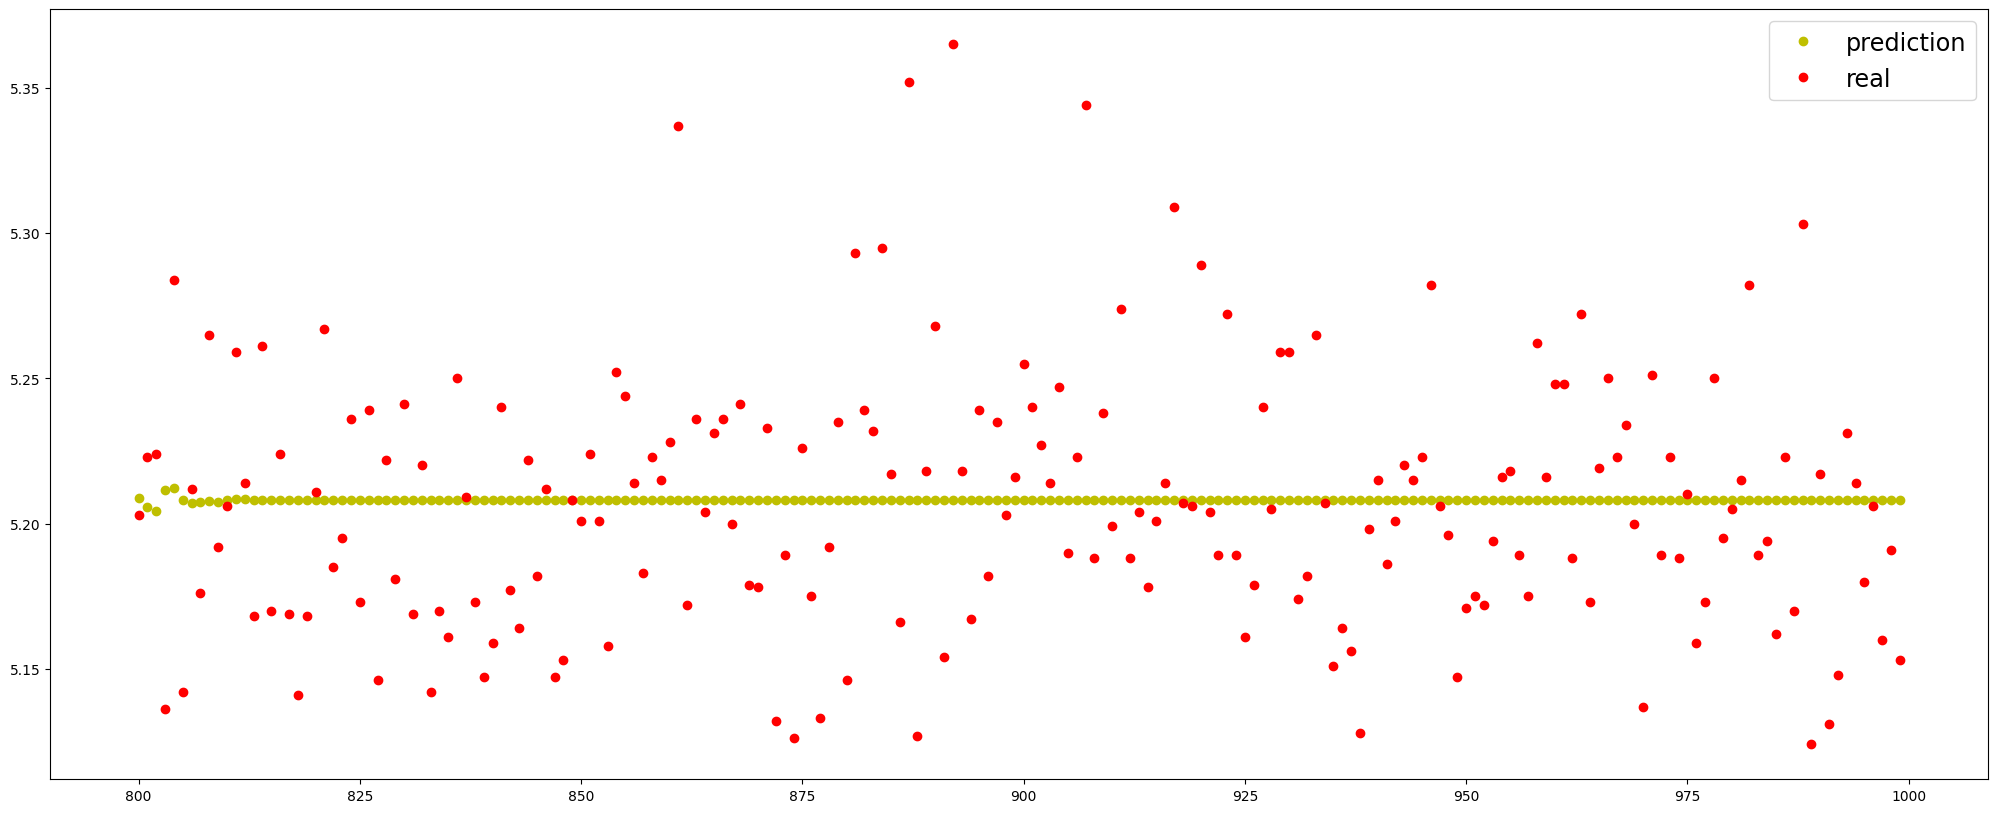

In [24]:
plotDifferencepredictions(pred,test_data)

In [25]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 93 underEstimates with mean 0.00886419801756572 
there are 107 overEstimates with mean 0.024683173504844783
total mean absolute pinball score 0.017327349903260018


(0.00886419801756572, 0.024683173504844783, 0.017327349903260018)

instead of predicting all test results at a time, do 1 by 1 and relearn like  our framework can do

In [26]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = AutoReg(diff_df["sec"][:i], lags=10).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])


In [27]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 92 underEstimates with mean 0.009244003971309079 
there are 108 overEstimates with mean 0.024898724841082527
total mean absolute pinball score 0.017697553240986735


(0.009244003971309079, 0.024898724841082527, 0.017697553240986735)

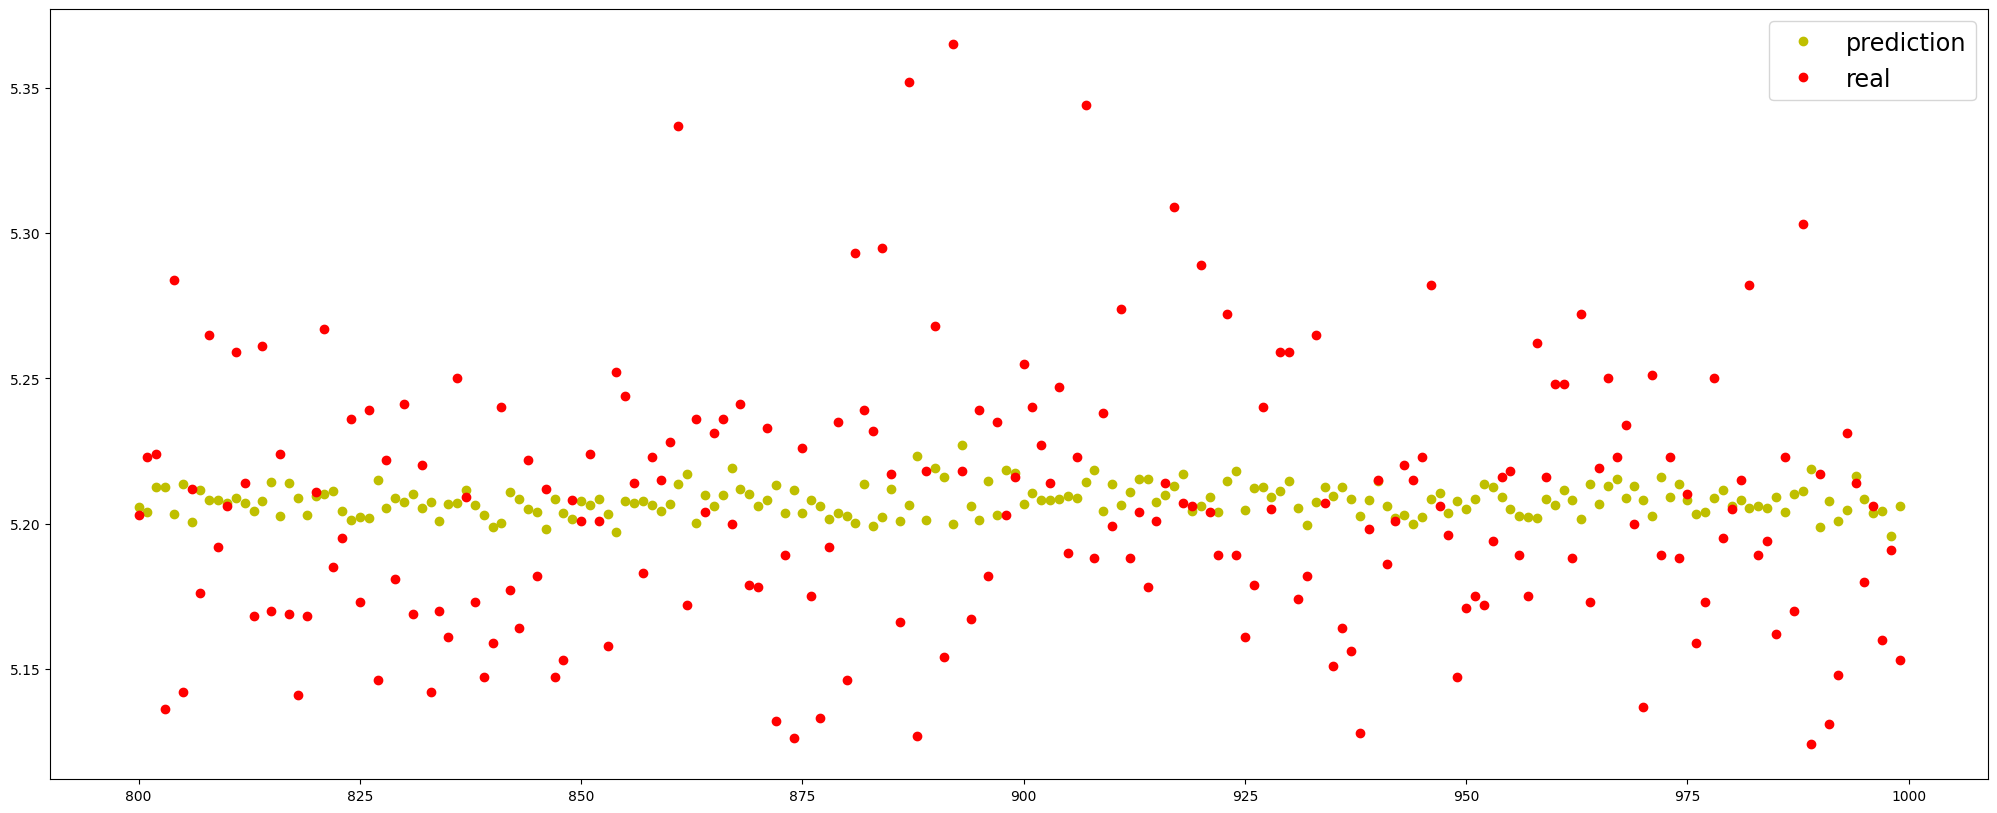

In [28]:
plotDifferencepredictions(pred,test_data)

as expected  we do not  see a lot of improvement

# arima

In [29]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [30]:
adf,pval,_,_,_,_ = adfuller(diff_df["sec"])
print(f"p value {pval} < 0.05 => stationairy")

p value 1.7417236011374657e-24 < 0.05 => stationairy


choose what arima model

In [31]:
model = pm.auto_arima(diff_df["sec"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6152.731, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2472.050, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5069.922, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1853.852, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1856.332, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1853.352, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1854.101, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1855.204, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1854.695, Time=0.70 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1856.101, Time=1.28 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 5.271 seconds


In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -922.676
Date:                Mon, 20 Mar 2023   AIC                           1853.352
Time:                        12:28:08   BIC                           1872.983
Sample:                             0   HQIC                          1860.813
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6063      0.265     17.362      0.000       4.086       5.126
ar.L1          0.0643      0.013      4.988      0.000       0.039       0.090
ar.L2          0.0506      0.048      1.048      0.295      -0.044       0.145
sigma2         0.3706      0.002    232.902      0.000       0.368       0.374
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          11316047.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            16.98
Prob(H) (two-sided):                  0.00   Kurtosis:                       523.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model = ARIMA(train_data, order=(2, 0, 0))

In [34]:
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  800
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -826.978
Date:                Mon, 20 Mar 2023   AIC                           1661.956
Time:                        12:28:08   BIC                           1680.695
Sample:                             0   HQIC                          1669.155
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2039      0.042    124.055      0.000       5.122       5.286
ar.L1          0.0641      0.016      3.975      0.000       0.033       0.096
ar.L2          0.0501      0.059      0.843      0.399      -0.066       0.167
sigma2         0.4628      0.002    186.321      0.000       0.458       0.468
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           5808909.57
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            15.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       419.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
pred = result.predict(start=startTestIndex, end=endtestIndex)

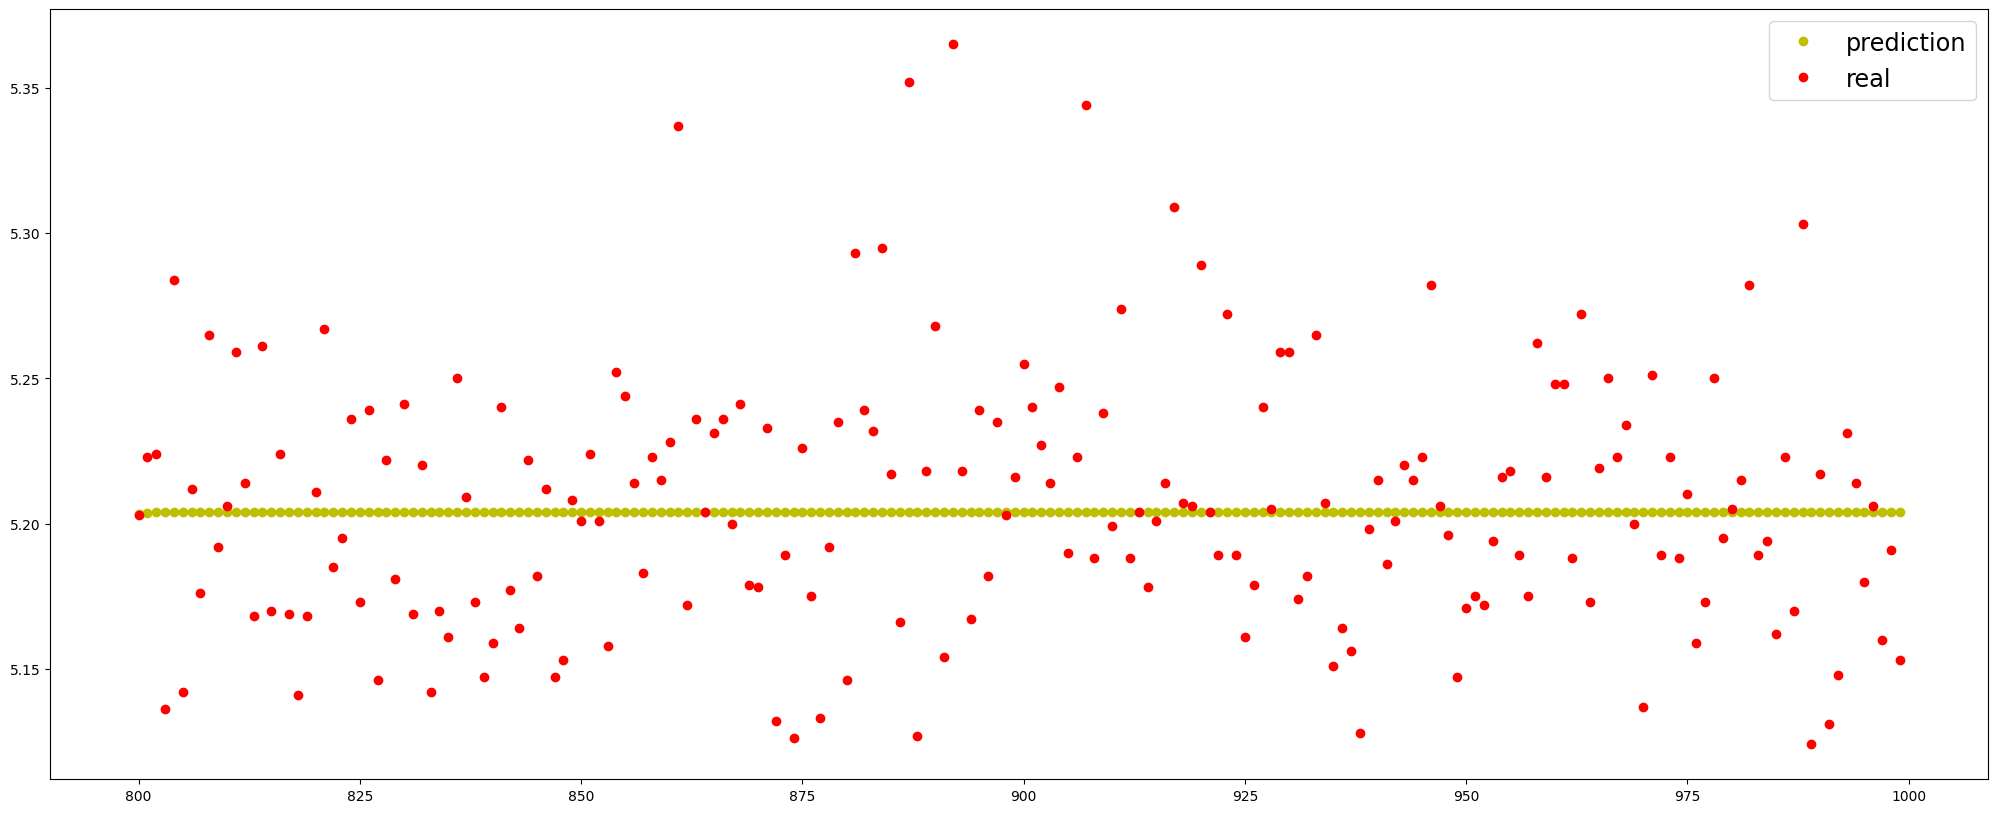

In [36]:
plotDifferencepredictions(pred,test_data)

In [37]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 105 underEstimates with mean 0.008824387377224399 
there are 95 overEstimates with mean 0.024399480096544468
total mean absolute pinball score 0.016222556418901433


(0.008824387377224399, 0.024399480096544468, 0.016222556418901433)

In [38]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = ARIMA(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])

In [39]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 99 underEstimates with mean 0.00932542573735128 
there are 101 overEstimates with mean 0.023602233898079396
total mean absolute pinball score 0.01653521385851898


(0.00932542573735128, 0.023602233898079396, 0.01653521385851898)

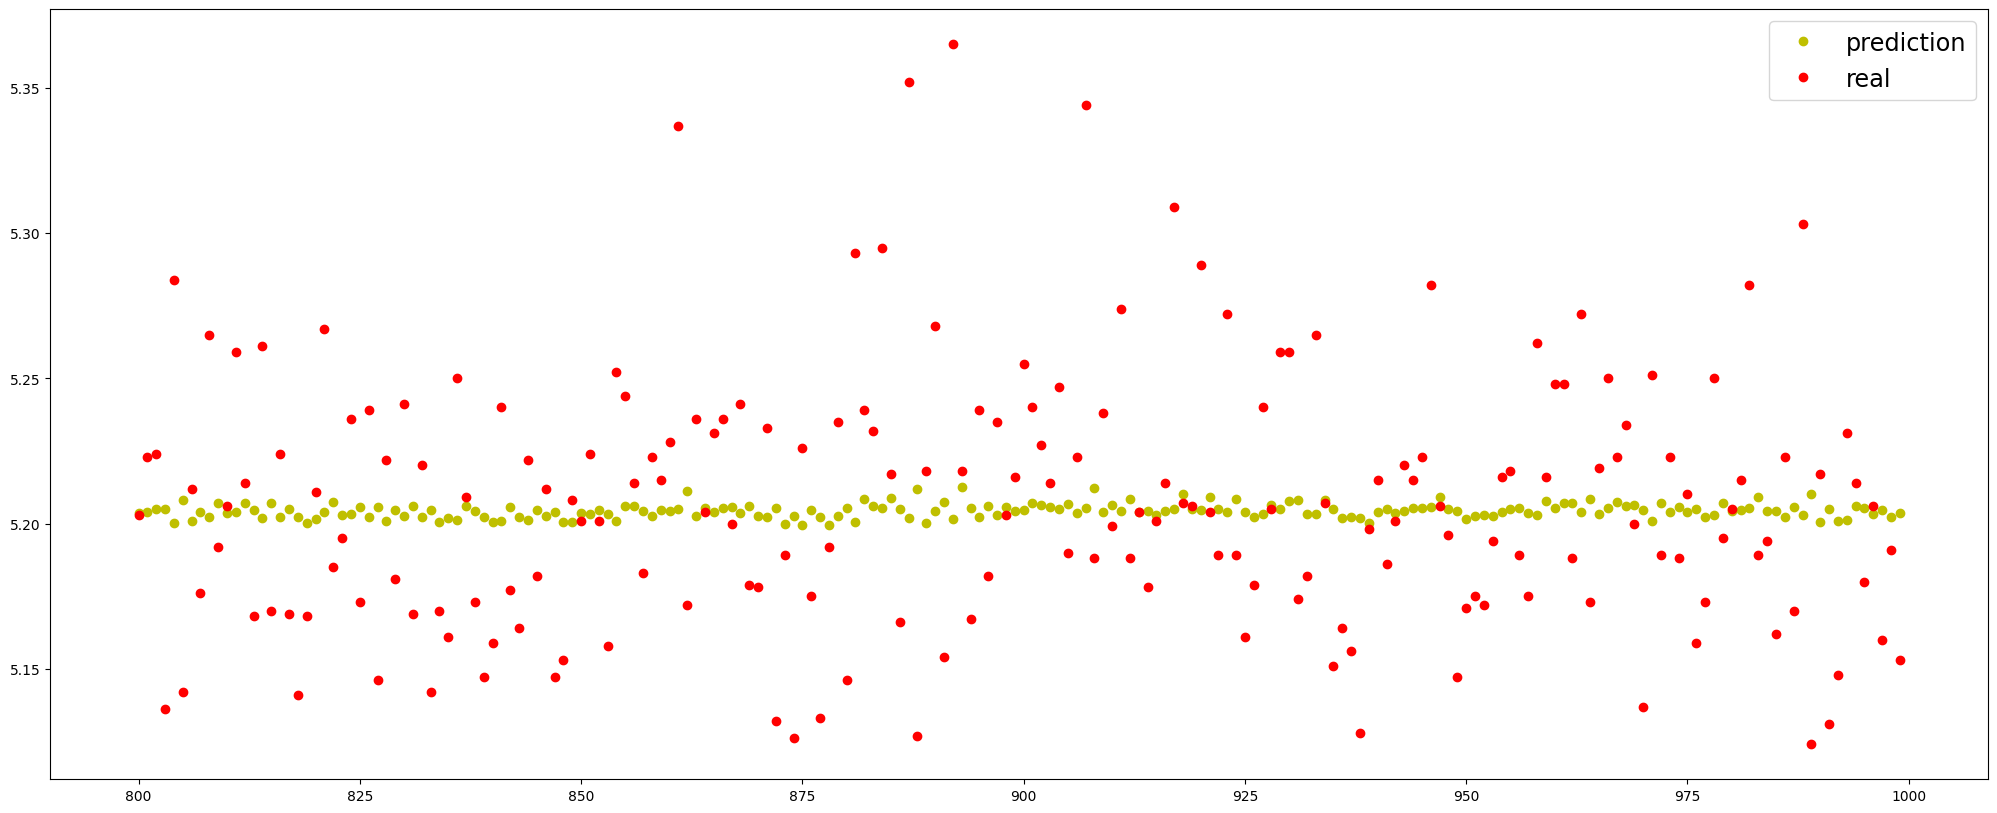

In [40]:
plotDifferencepredictions(pred,test_data)

# sarima

our data is  not really  seasonal so  skip this

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
model = SARIMAX(train_data, order=(2, 0, 0))

In [43]:
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20922D+00    |proj g|=  4.57167D-03

At iterate    5    f=  1.20922D+00    |proj g|=  7.02219D-04

At iterate   10    f=  1.20921D+00    |proj g|=  6.23692D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.237D-06   1.209D+00
  F =   1.2092059222922071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  800
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -967.365
Date:                Mon, 20 Mar 2023   AIC                           1940.729
Time:                        12:28:31   BIC                           1954.783
Sample:                             0   HQIC                          1946.128
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5034      0.004    128.429      0.000       0.496       0.511
ar.L2          0.4882      0.005    105.484      0.000       0.479       0.497
sigma2         0.6541      0.003    210.780      0.000       0.648       0.660
===================================================================================
Ljung-Box (L1) (Q):                  13.49   Jarque-Bera (JB):           1804531.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             7.67
Prob(H) (two-sided):                  0.00   Kurtosis:                       235.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
pred = result.predict(start=startTestIndex, end=endtestIndex)

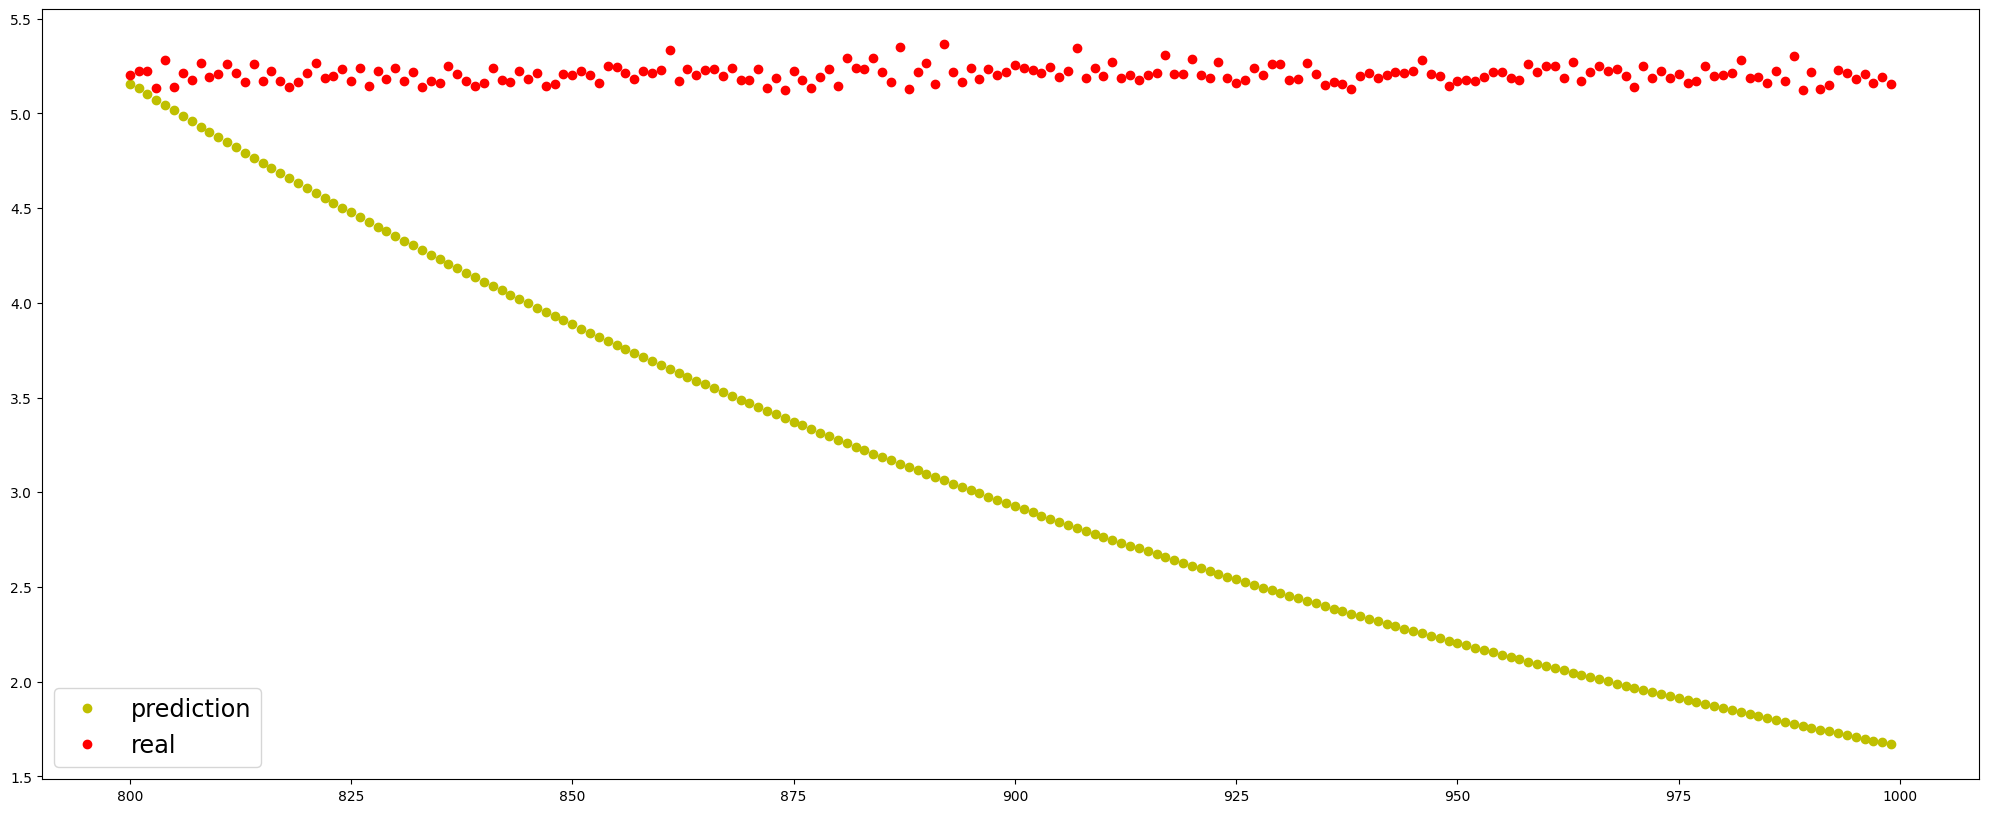

In [45]:
plotDifferencepredictions(pred,test_data)

In [46]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 200 underEstimates with mean 0.5281108210663504 
there are 0 overEstimates with mean nan
total mean absolute pinball score 0.5281108210663504


/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/models/.venvModels/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/models/.venvModels/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.5281108210663504, nan, 0.5281108210663504)

predicting that far into the future is pritty bad

In [ ]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = SARIMAX(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])


In [48]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 171 underEstimates with mean 0.01828417405667318 
there are 29 overEstimates with mean 0.01960165803133733
total mean absolute pinball score 0.01847520923299948


(0.01828417405667318, 0.01960165803133733, 0.01847520923299948)

model predicts pritty good, underestimates more, which is better for our framework

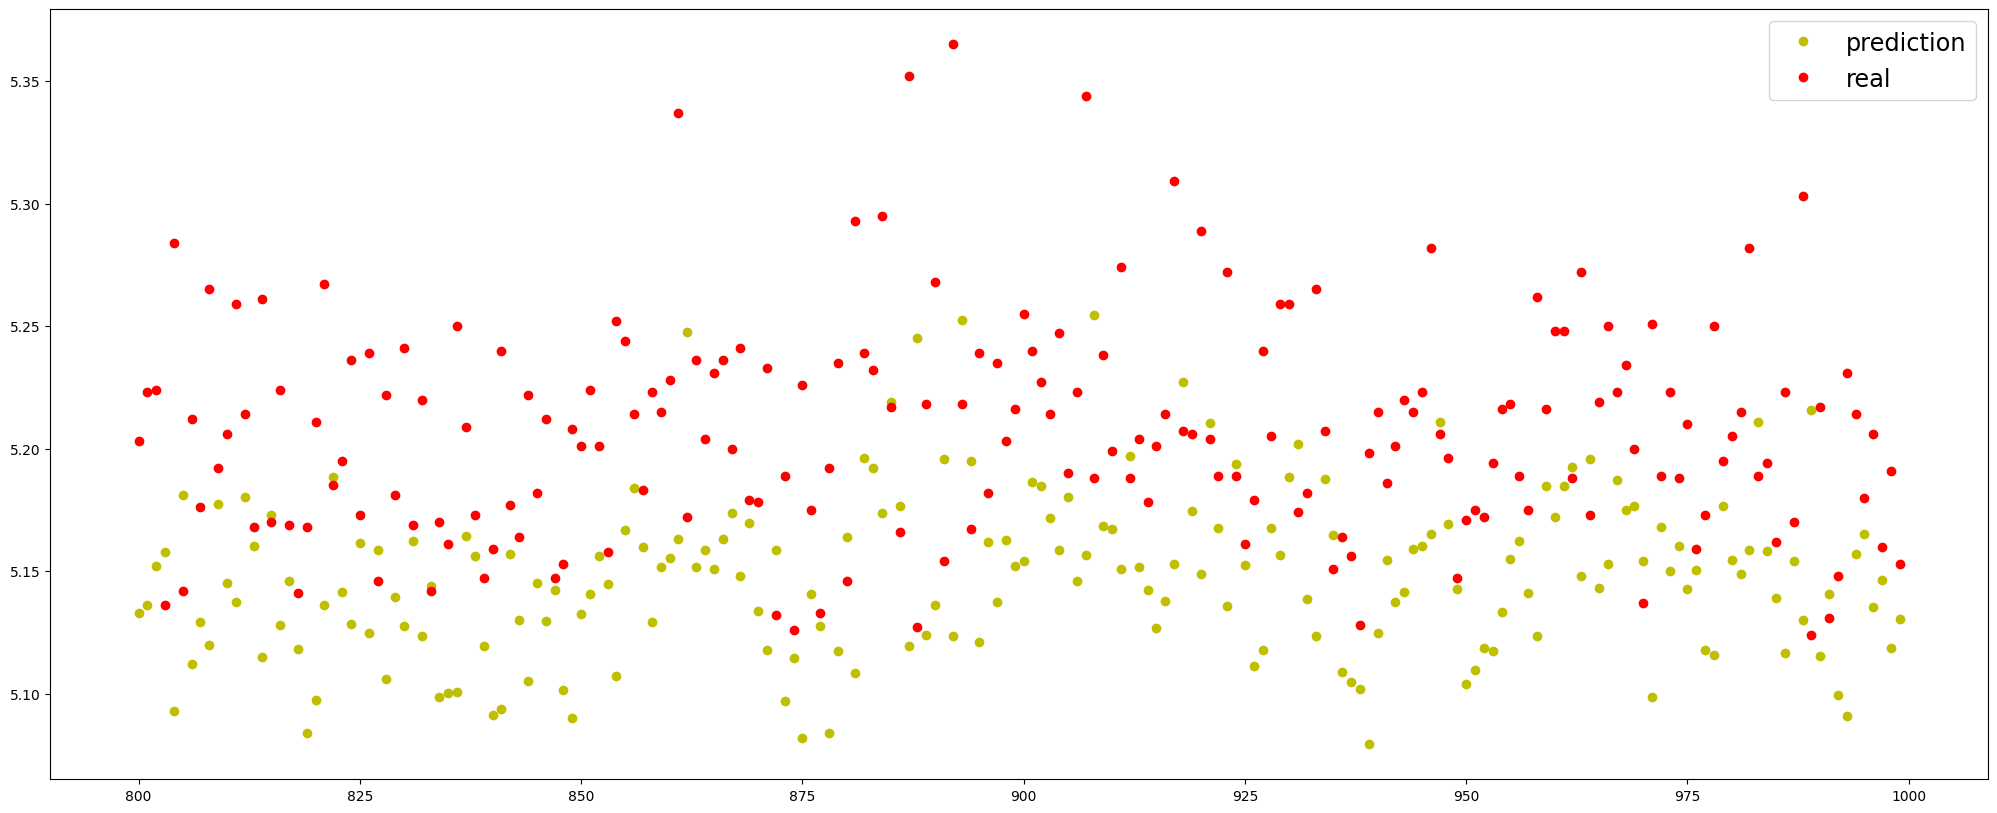

In [49]:
plotDifferencepredictions(pred,test_data)

# Exponential smoothing

## simple  smoothing

In [29]:
from statsmodels.tsa.api import  SimpleExpSmoothing

In [51]:
model = SimpleExpSmoothing(train_data, initialization_method="estimated")
result = model.fit()

In [52]:
pred =  result.predict(start=startTestIndex, end=endtestIndex)

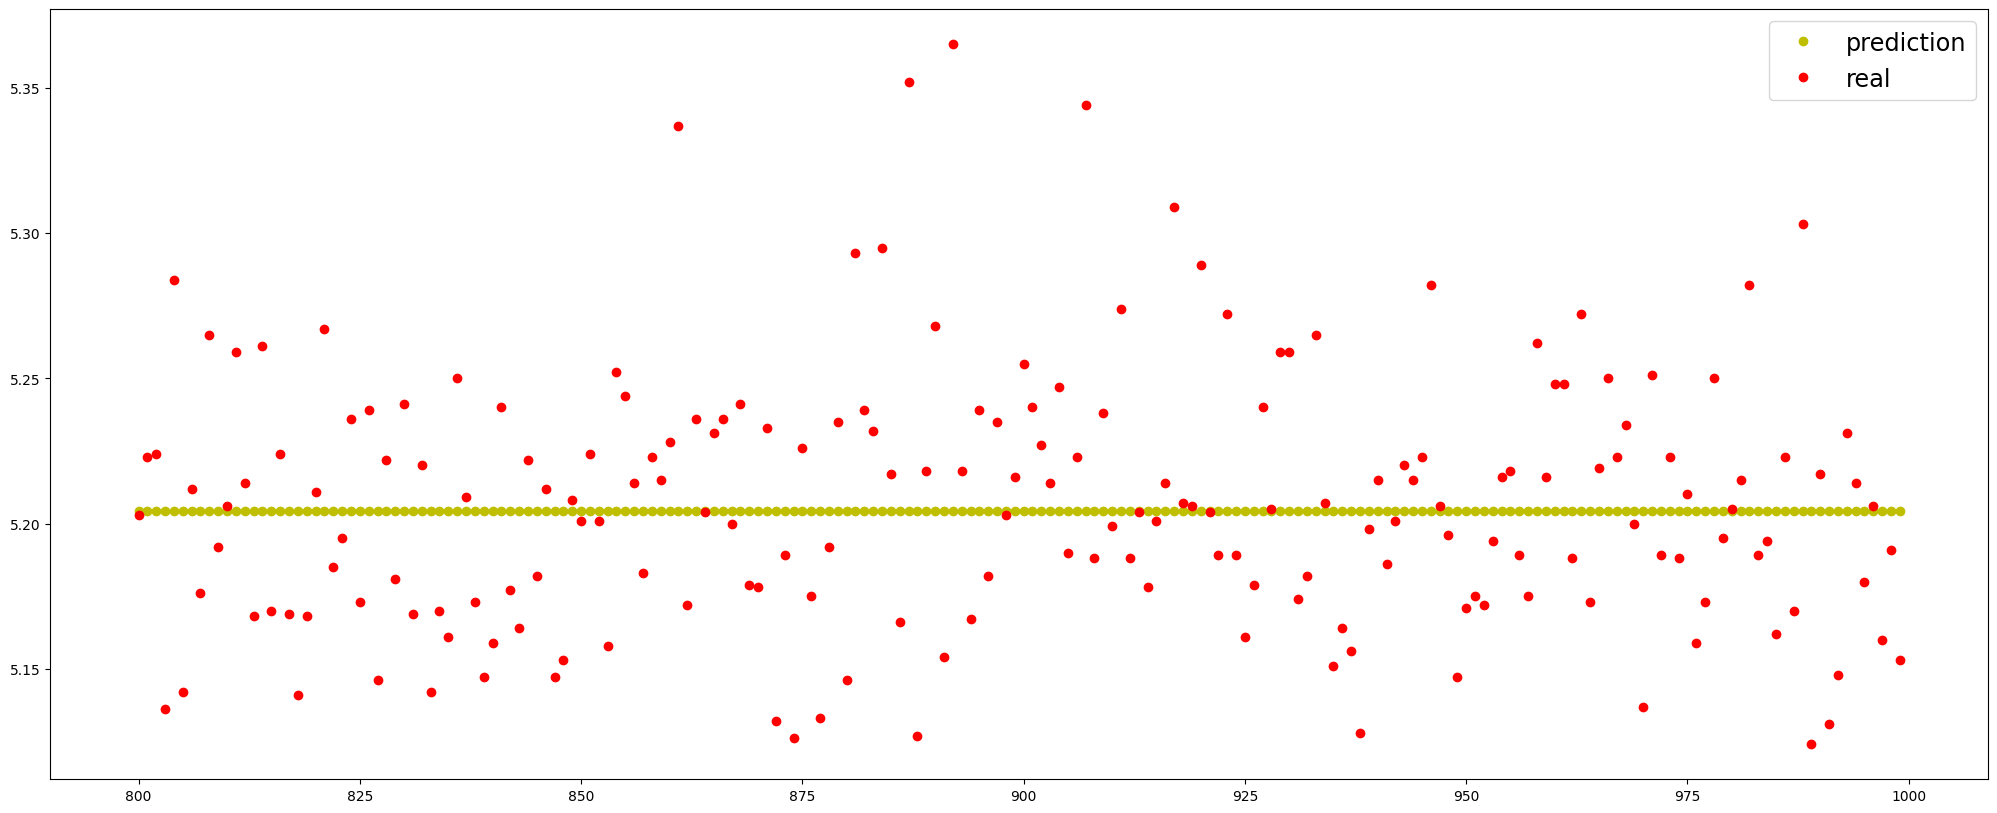

In [53]:
plotDifferencepredictions(pred,test_data)

In [54]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 102 underEstimates with mean 0.008976203648516283 
there are 98 overEstimates with mean 0.023972949678700898
total mean absolute pinball score 0.016324609203306743


(0.008976203648516283, 0.023972949678700898, 0.016324609203306743)

In [55]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = SimpleExpSmoothing(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [56]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 100 underEstimates with mean 0.00910203841044454 
there are 100 overEstimates with mean 0.023690504318524513
total mean absolute pinball score 0.01639627136448452


(0.00910203841044454, 0.023690504318524513, 0.01639627136448452)

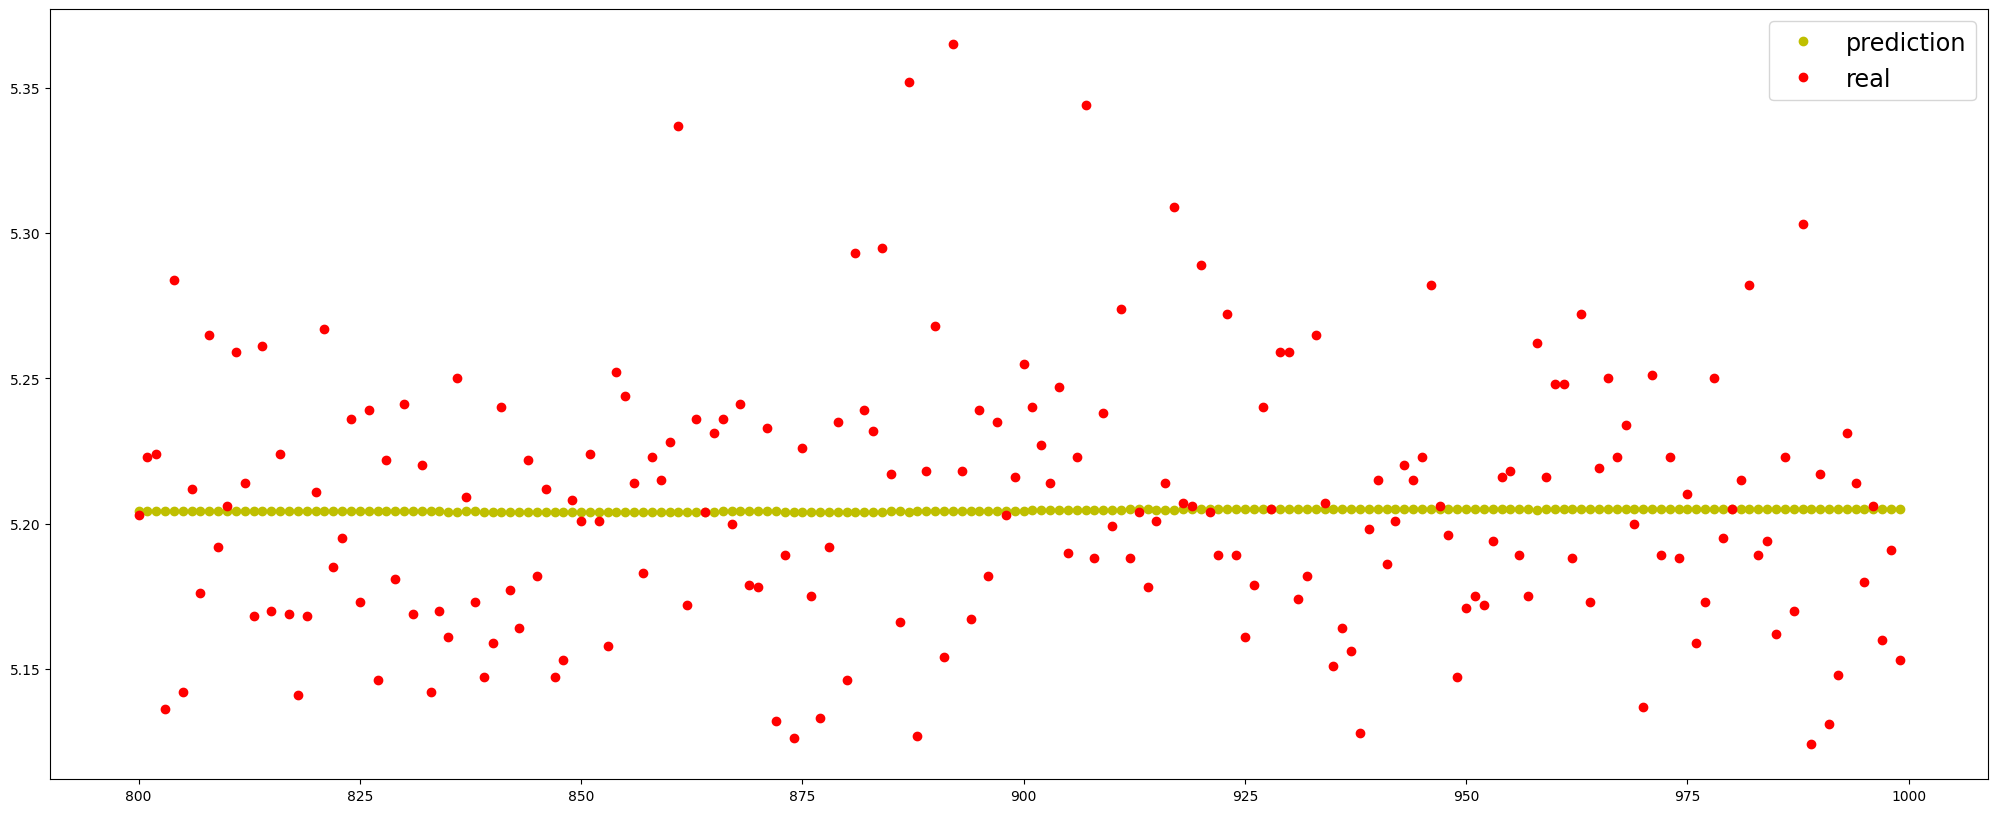

In [57]:
plotDifferencepredictions(pred,test_data)

##  Holt

In [58]:
from statsmodels.tsa.api import  Holt

In [59]:
model = Holt(train_data, initialization_method="estimated")
result = model.fit()

In [60]:
pred =  result.predict(start=startTestIndex, end=endtestIndex)

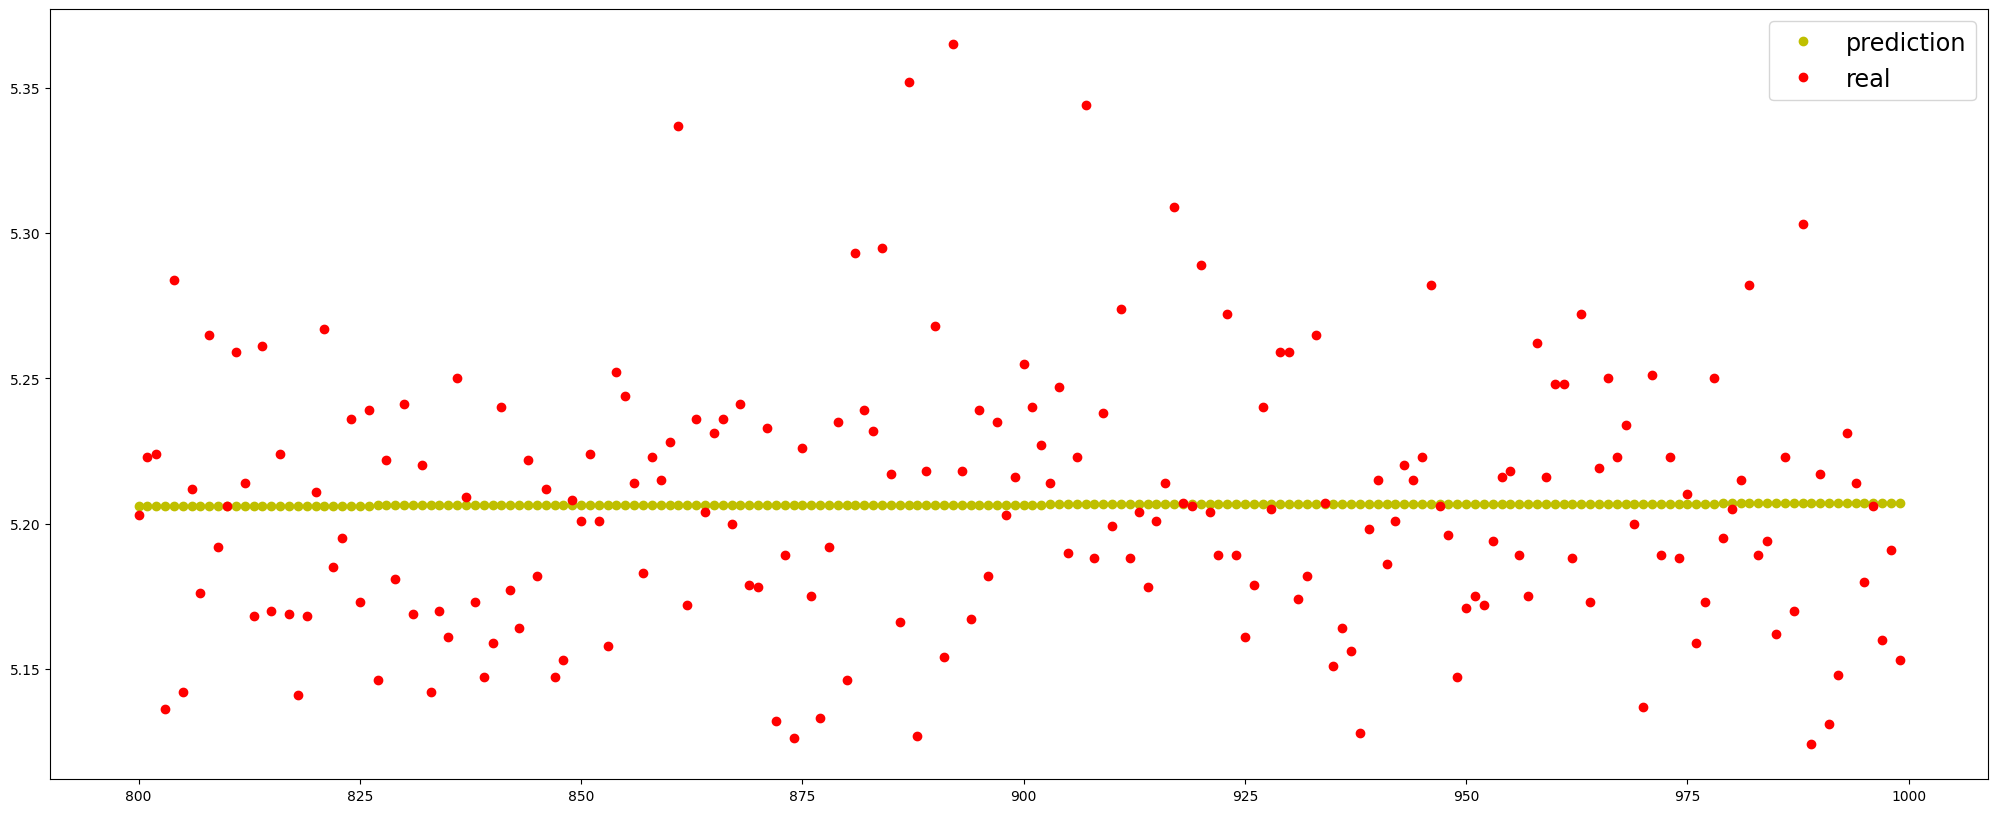

In [61]:
plotDifferencepredictions(pred,test_data)

In [62]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 96 underEstimates with mean 0.008962064828373932 
there are 104 overEstimates with mean 0.02421011925209374
total mean absolute pinball score 0.01689105312870823


(0.008962064828373932, 0.02421011925209374, 0.01689105312870823)

In [63]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = Holt(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [64]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 94 underEstimates with mean 0.009150895870901716 
there are 106 overEstimates with mean 0.024045705963195156
total mean absolute pinball score 0.017045145219817242


(0.009150895870901716, 0.024045705963195156, 0.017045145219817242)

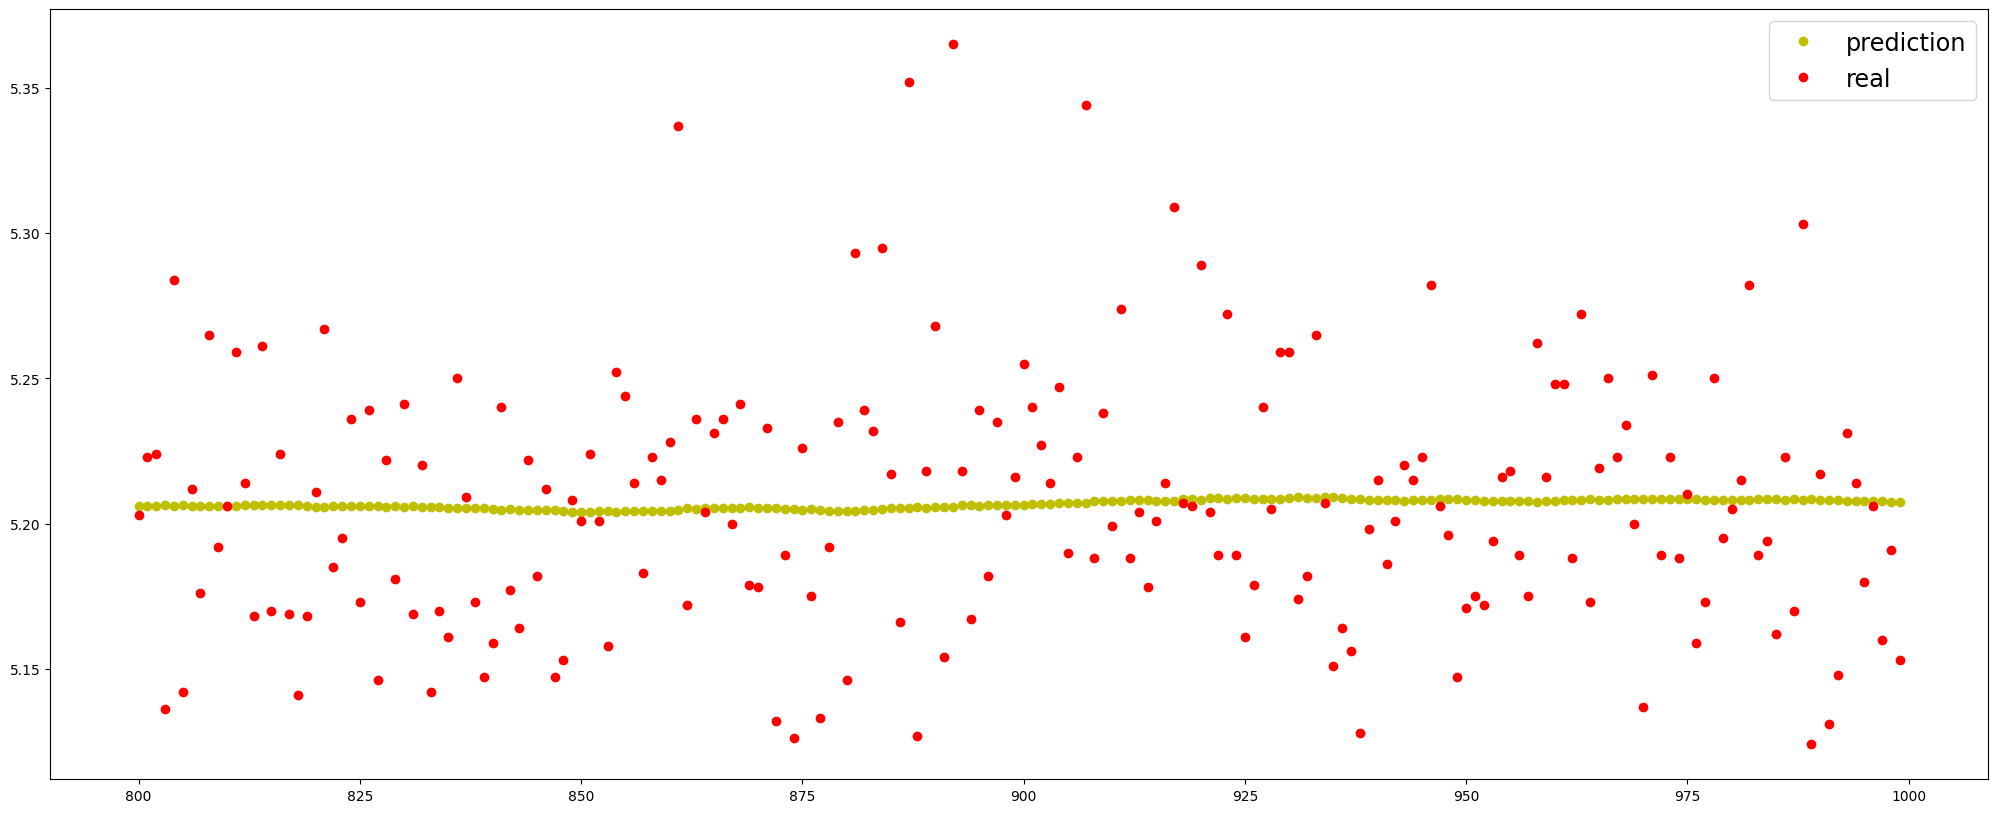

In [65]:
plotDifferencepredictions(pred,test_data)

# holtz winter

In [30]:
from statsmodels.tsa.api import ExponentialSmoothing



array([5.2199])

In [31]:
data  =  [5,5.05,5.1,4.68,4.88,4.99,5,5.12,5.42,5.19]
SimpleExpSmoothing(data, initialization_method="estimated").fit().predict(start=len(data), end=len(data))

array([5.2199])

In [16]:
data  =  [5,5.05,5.1,4.68,4.88,4.99,5,5.12,5.42,5.19]
ExponentialSmoothing(data, initialization_method="estimated").fit().predict(start=len(data), end=len(data))

array([5.2199])

In [67]:
model = ExponentialSmoothing(train_data, initialization_method="estimated")
result = model.fit()
pred =  result.predict(start=startTestIndex, end=endtestIndex)

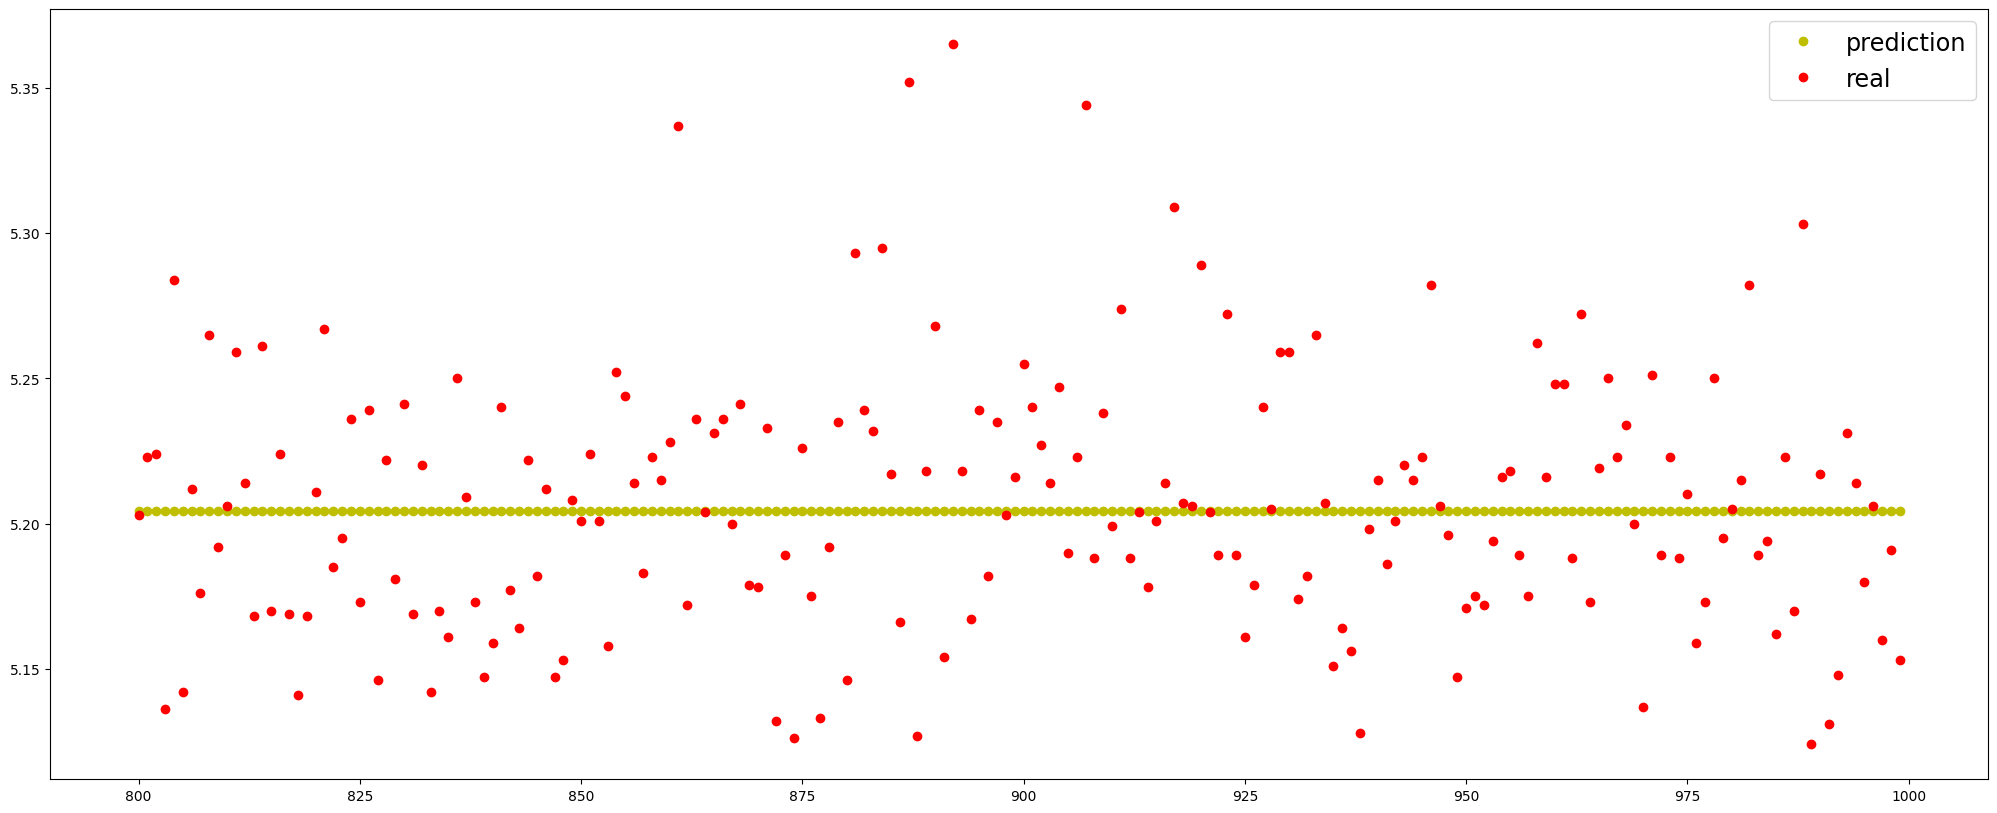

In [68]:
plotDifferencepredictions(pred,test_data)

In [69]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 102 underEstimates with mean 0.008976203648516283 
there are 98 overEstimates with mean 0.023972949678700898
total mean absolute pinball score 0.016324609203306743


(0.008976203648516283, 0.023972949678700898, 0.016324609203306743)

In [70]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = ExponentialSmoothing(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [71]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 100 underEstimates with mean 0.00910203841044454 
there are 100 overEstimates with mean 0.023690504318524513
total mean absolute pinball score 0.01639627136448452


(0.00910203841044454, 0.023690504318524513, 0.01639627136448452)

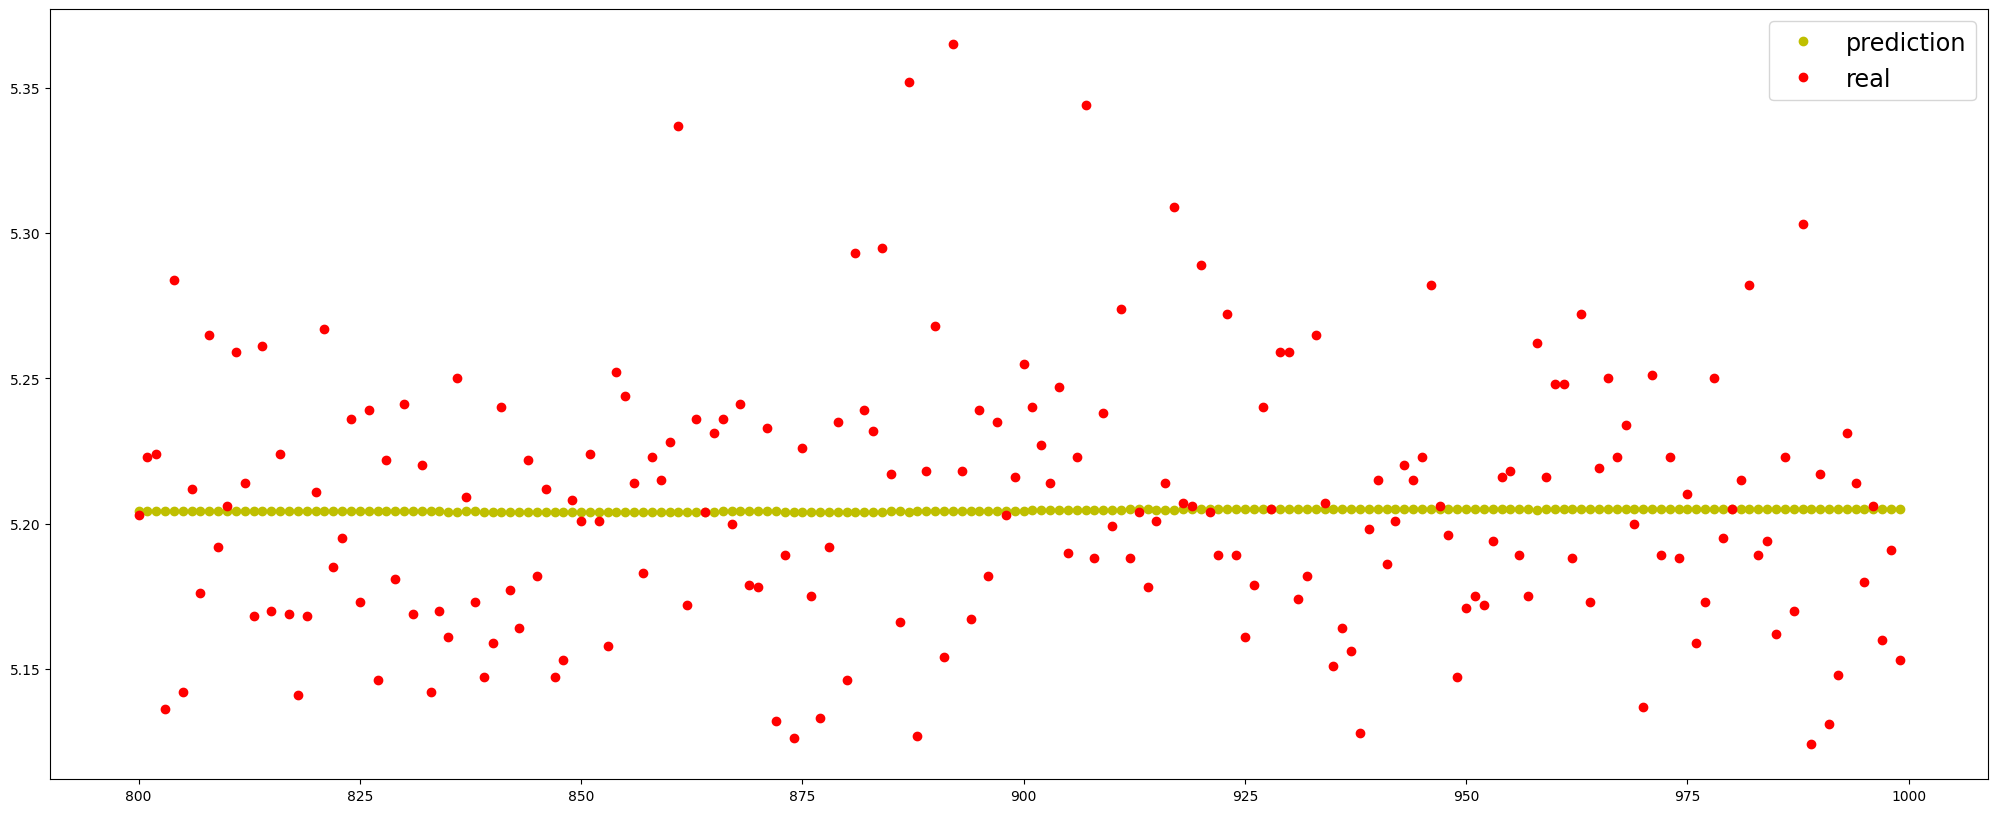

In [72]:
plotDifferencepredictions(pred,test_data)

# LSTM

In [4]:
#https://medium.com/@nutanbhogendrasharma/simple-sequence-prediction-with-lstm-69ff0f4d57cd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

def splitSequence(seq, n_steps):
    
    X = []
    y = []

    stopindex = len(seq)-n_steps
    
    for i in range(stopindex):
        #get the last index
        lastIndex = i + n_steps
        
        #Create input and output sequence
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]
        
        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)     #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X,y 



2023-05-08 10:26:42.656865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 10:26:47.766413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-08 10:26:47.766461: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-08 10:26:56.631061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
n_steps  = 20

#  TODO rescale /normalize data ?

X,y = splitSequence(train_data,n_steps)

In [5]:
# reshape from [samples, timesteps] into [samples, timesteps, features]n_features = 1
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X[:2])

NameError: name 'X' is not defined

In [58]:
model = tf.keras.Sequential()
model.add(layers.LSTM(30,return_sequences=True ,activation='relu', input_shape=(n_steps, n_features)))
model.add(layers.LSTM(units=10, return_sequences=True))
model.add(layers.LSTM(units=10))
model.add(layers.Dense(1))

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 30)            3840      
                                                                 
 lstm_5 (LSTM)               (None, 20, 10)            1640      
                                                                 
 lstm_6 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 6,331
Trainable params: 6,331
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tfa.losses.PinballLoss(tau=.25), metrics=['mean_absolute_error'])

In [62]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
25/25 [==============================] - 6s 19ms/step - loss: 0.5218 - mean_absolute_error: 2.0390
Epoch 2/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0609 - mean_absolute_error: 0.1698
Epoch 3/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0401 - mean_absolute_error: 0.1089
Epoch 4/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0387 - mean_absolute_error: 0.1033
Epoch 5/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0377 - mean_absolute_error: 0.0990
Epoch 6/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0376 - mean_absolute_error: 0.0999
Epoch 7/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0375 - mean_absolute_error: 0.0994
Epoch 8/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0380 - mean_absolute_error: 0.1014
Epoch 9/200
25/25 [==============================] - 1s 21ms/step - loss: 0.0377 - mean_absolute_error: 0.1002
E

In [63]:
pred = []
for i in range(startTestIndex,len(diff_df)):

    hist = np.array(diff_df["sec"][i-n_steps:i]).reshape((1, n_steps, n_features))
    predict = model.predict(hist, verbose=1)
    pred.append(predict[0][0])

1/1 [==============================] - 0s 25ms/step


In [64]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 151 underEstimates with mean 0.012392263103005115 
there are 49 overEstimates with mean 0.014479650750452187
total mean absolute pinball score 0.012903673076629646


(0.012392263103005115, 0.014479650750452187, 0.012903673076629646)

In [13]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 160 underEstimates with mean 0.01291830211281777 
there are 40 overEstimates with mean 0.013762798976898239
total mean absolute pinball score 0.013087201485633861


(0.01291830211281777, 0.013762798976898239, 0.013087201485633861)

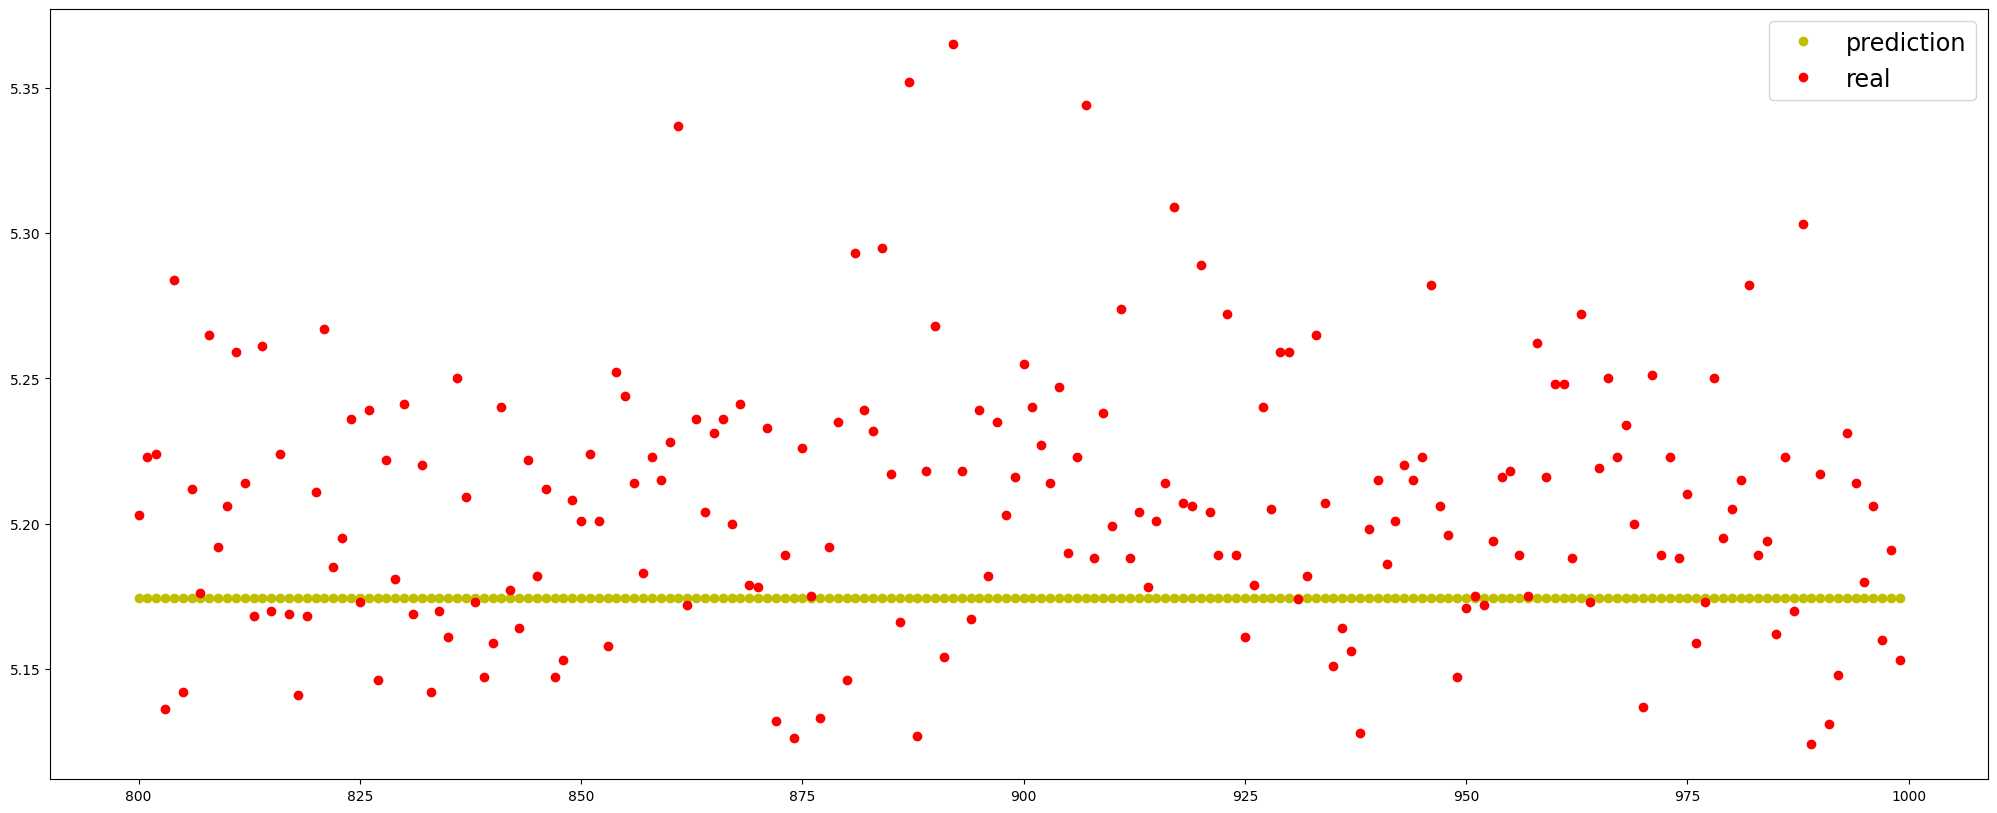

In [65]:
plotDifferencepredictions(pred,test_data,test_data.index)

# SERVERTESTS

In [5]:
from collections import deque
import requests
from datetime import datetime as dt, timezone, timedelta
import time

In [9]:
def predictServer(function,df,bufferlen=50):
    q =  deque(maxlen=bufferlen)
    pred  = []

    for i in range(len( df['reconsile_dates'])-1):
        q.append(df['reconsile_dates'][i])
        history = [x.strftime('%Y-%m-%dT%H:%M:%S.%fZ') for x in q]
        r = requests.post('http://127.0.0.1:5000/prediction',json= {"history":history, "function": function})
        predictionstr  = r.json()["prediction"]
        predictiondate =  dt.strptime(predictionstr, '%Y-%m-%dT%H:%M:%S.%fZ')
        #print(predictiondate,df['reconsile_dates'][i+1].replace(tzinfo=None))
        secdif = (predictiondate - df['reconsile_dates'][i+1].replace(tzinfo=None)).total_seconds()
        pred.append(secdif)
        #time.sleep(2)
    
    #total_perside_piball_loss(np.zeros(len(pred)),pred)
    return pred



In [10]:

#        load back mem                       predicted                            CURRENT
#               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|
#                                                                                          


def calculateStatistics(timediffs, TIMEBEFOREPREDICTEDMs=0.5, GRACEPERIODMs=0.5, debug=True ):

    missesBeforeTIMEBEFOREPREDICTEDMs =0
    missesAfterGRACEPERIODMs  =  0
    caughtTIMEBEFOREPREDICTEDMs =  0
    caughtGRACEPERIODMs = 0
    for timedif in timediffs:
        if timedif < -TIMEBEFOREPREDICTEDMs:
            missesBeforeTIMEBEFOREPREDICTEDMs+=1
        elif timedif > GRACEPERIODMs:
            missesAfterGRACEPERIODMs+=1
        elif timedif <  0:
            caughtTIMEBEFOREPREDICTEDMs+=1
        elif timedif >  0:
            caughtGRACEPERIODMs+=1
    
    accuracy = (caughtGRACEPERIODMs+caughtTIMEBEFOREPREDICTEDMs)/len(timediffs)
    if not debug:
        return  accuracy

    print(f"        load back mem                       predicted                            CURRENT")
    print(f"               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|")
    print(f"    {missesBeforeTIMEBEFOREPREDICTEDMs}                         {caughtTIMEBEFOREPREDICTEDMs}                              {caughtGRACEPERIODMs}                          {missesAfterGRACEPERIODMs}")
    print(f"accuracy= {accuracy}")
    return accuracy





In [32]:
pred  =  predictServer("autoReg",df,bufferlen=50)

there are 468 underEstimates with mean 0.2976224551282053 
there are 532 overEstimates with mean 2.017526461466165
total mean absolute pinball score 1.2126113864999999


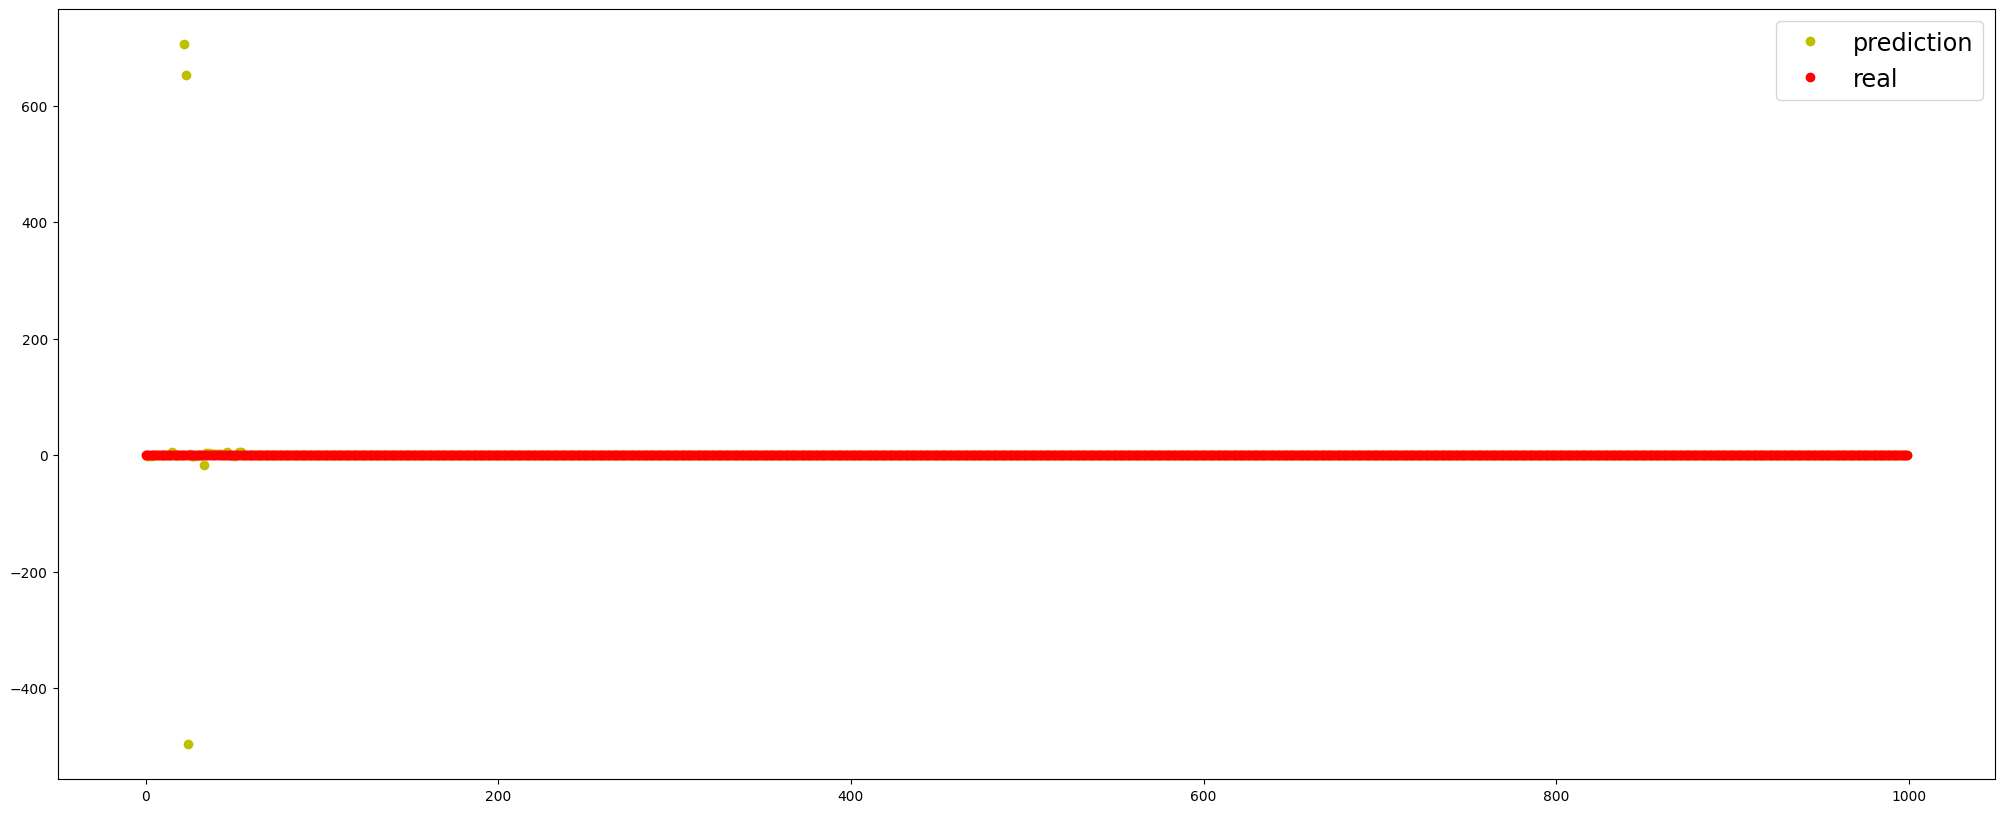

In [33]:
plotDifferencepredictions(pred,np.zeros(len(pred)))


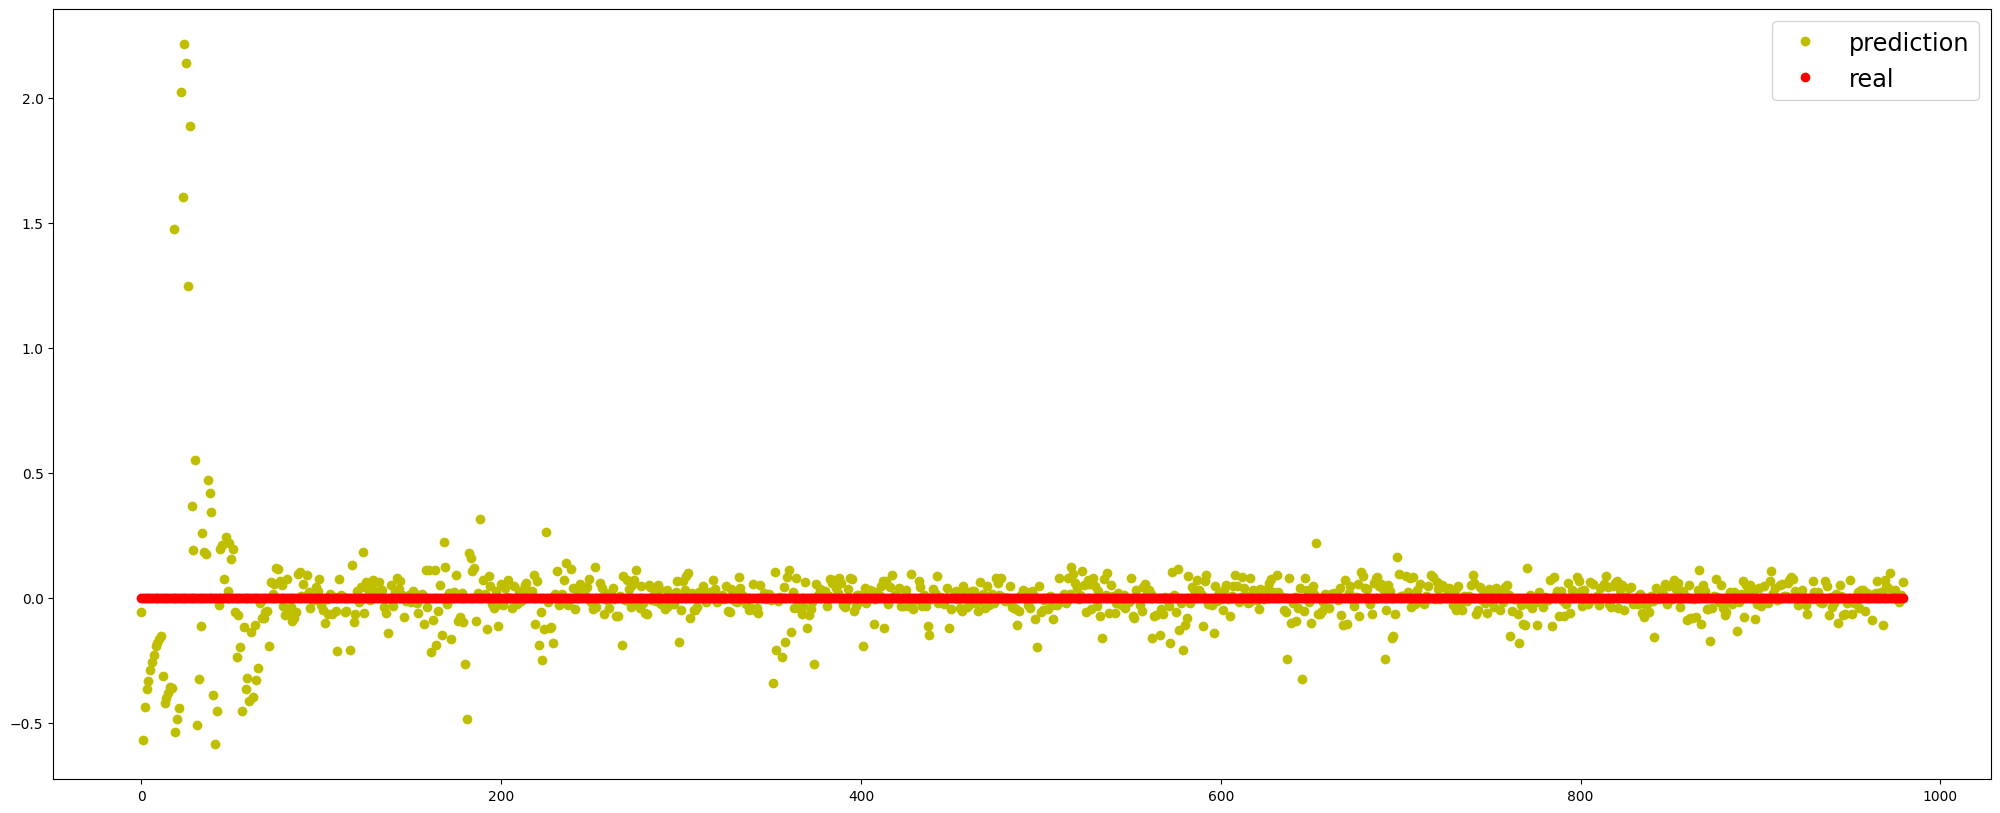

In [34]:
lowerb, upperbound =  np.percentile(pred,[1,99])
perclist = [x for x in pred if lowerb < x <  upperbound]

plotDifferencepredictions(perclist,np.zeros(len(perclist)))

In [35]:
calculateStatistics(pred)

        load back mem                       predicted                            CURRENT
               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|
    14                         454                              514                          18
accuracy= 0.968


0.968

ARIMA

there are 466 underEstimates with mean 0.03100087660944206 
there are 534 overEstimates with mean 0.061608681179775276
total mean absolute pinball score 0.04734544425


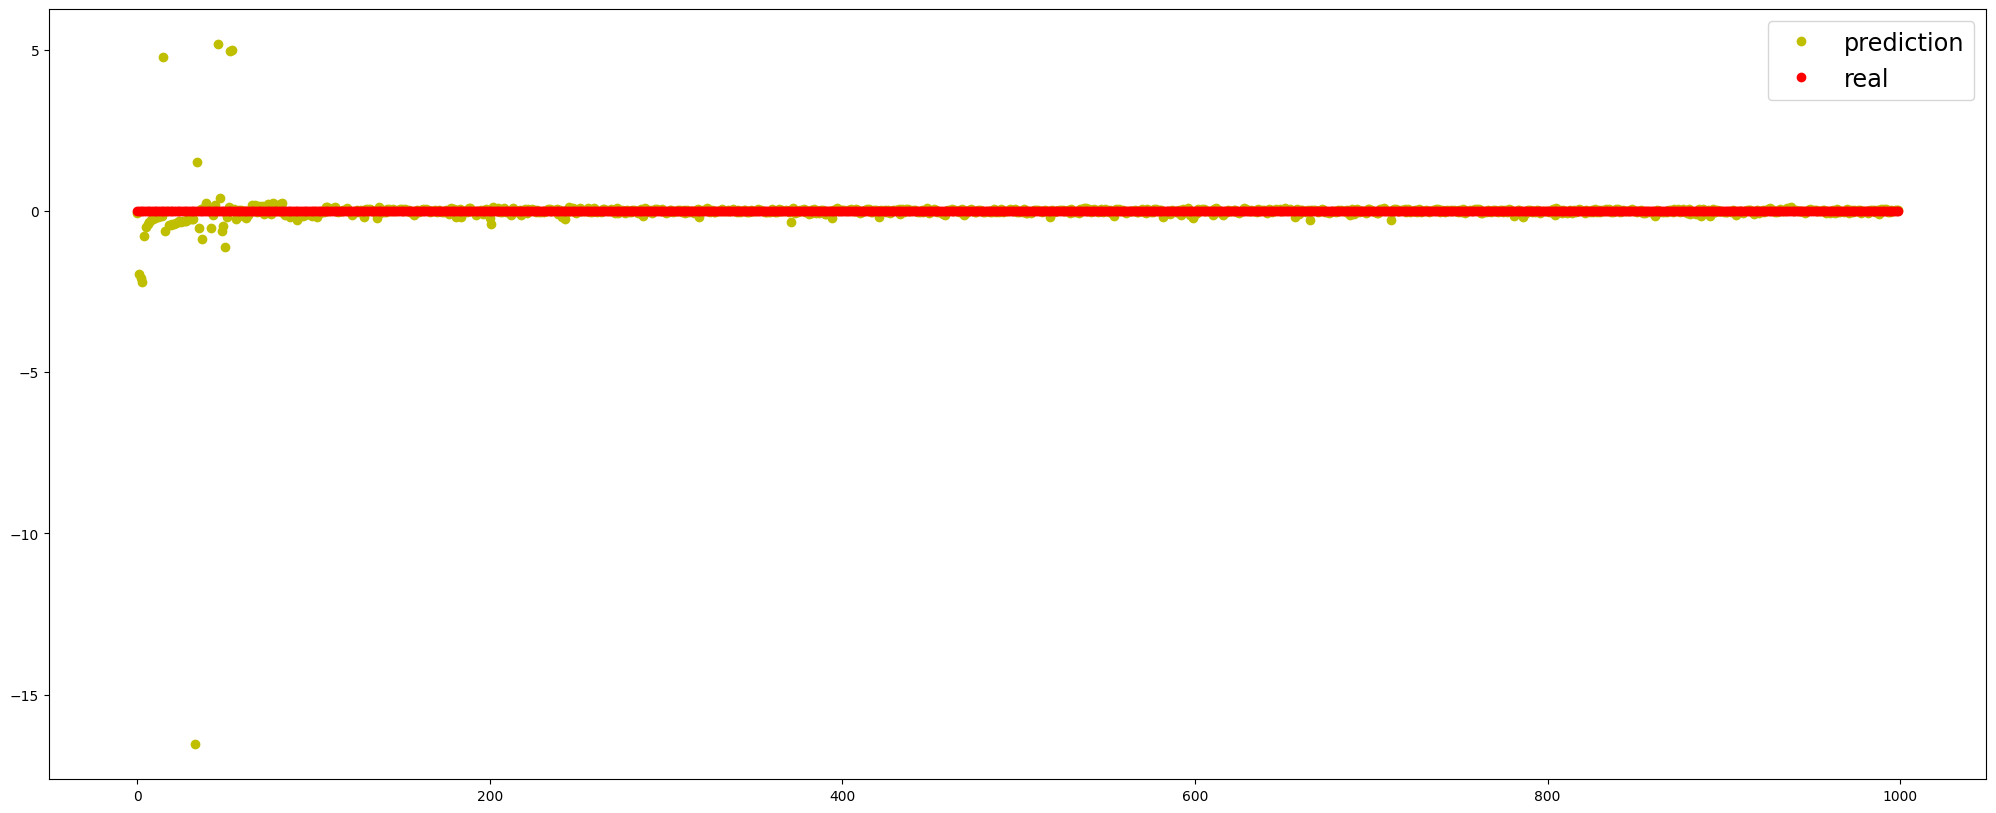

In [36]:
pred  =  predictServer("ARIMA",bufferlen=50)
plotDifferencepredictions(pred,np.zeros(len(pred)))

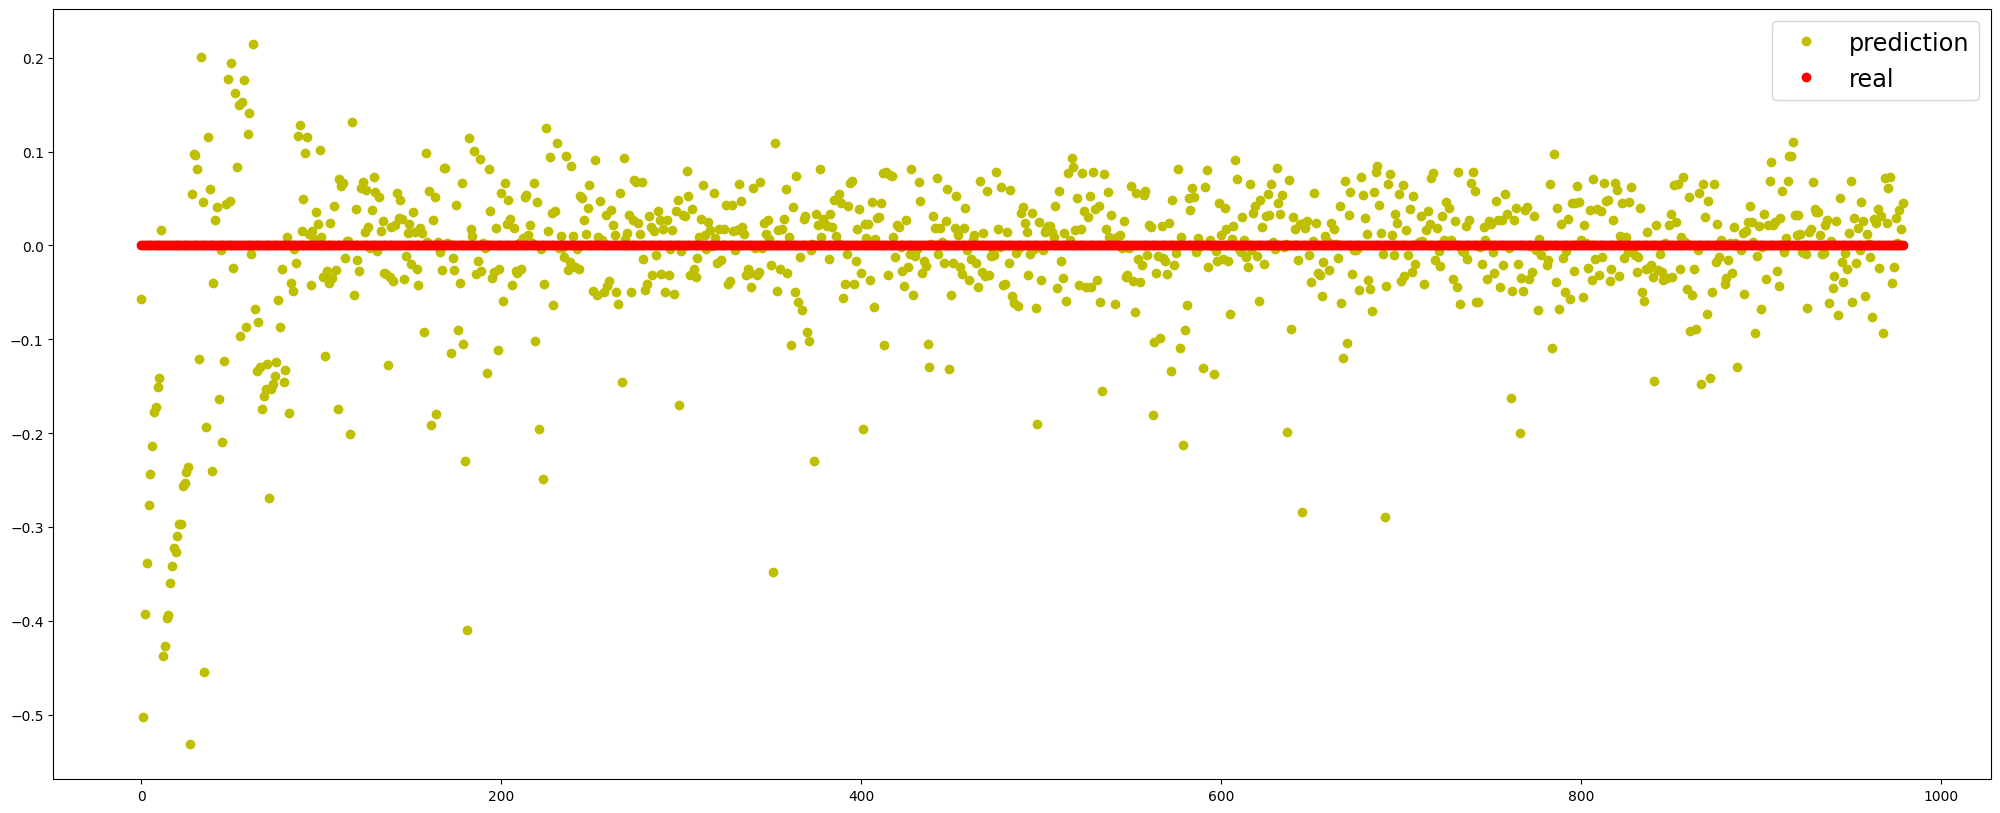

In [37]:
lowerb, upperbound =  np.percentile(pred,[1,99])
perclist = [x for x in pred if lowerb < x <  upperbound]

plotDifferencepredictions(perclist,np.zeros(len(perclist)))

In [38]:
calculateStatistics(pred)

        load back mem                       predicted                            CURRENT
               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|
    12                         454                              529                          5
accuracy= 0.983


0.983

SES

there are 459 underEstimates with mean 0.02777040413943355 
there are 541 overEstimates with mean 0.05934479390018484
total mean absolute pinball score 0.044852148999999994


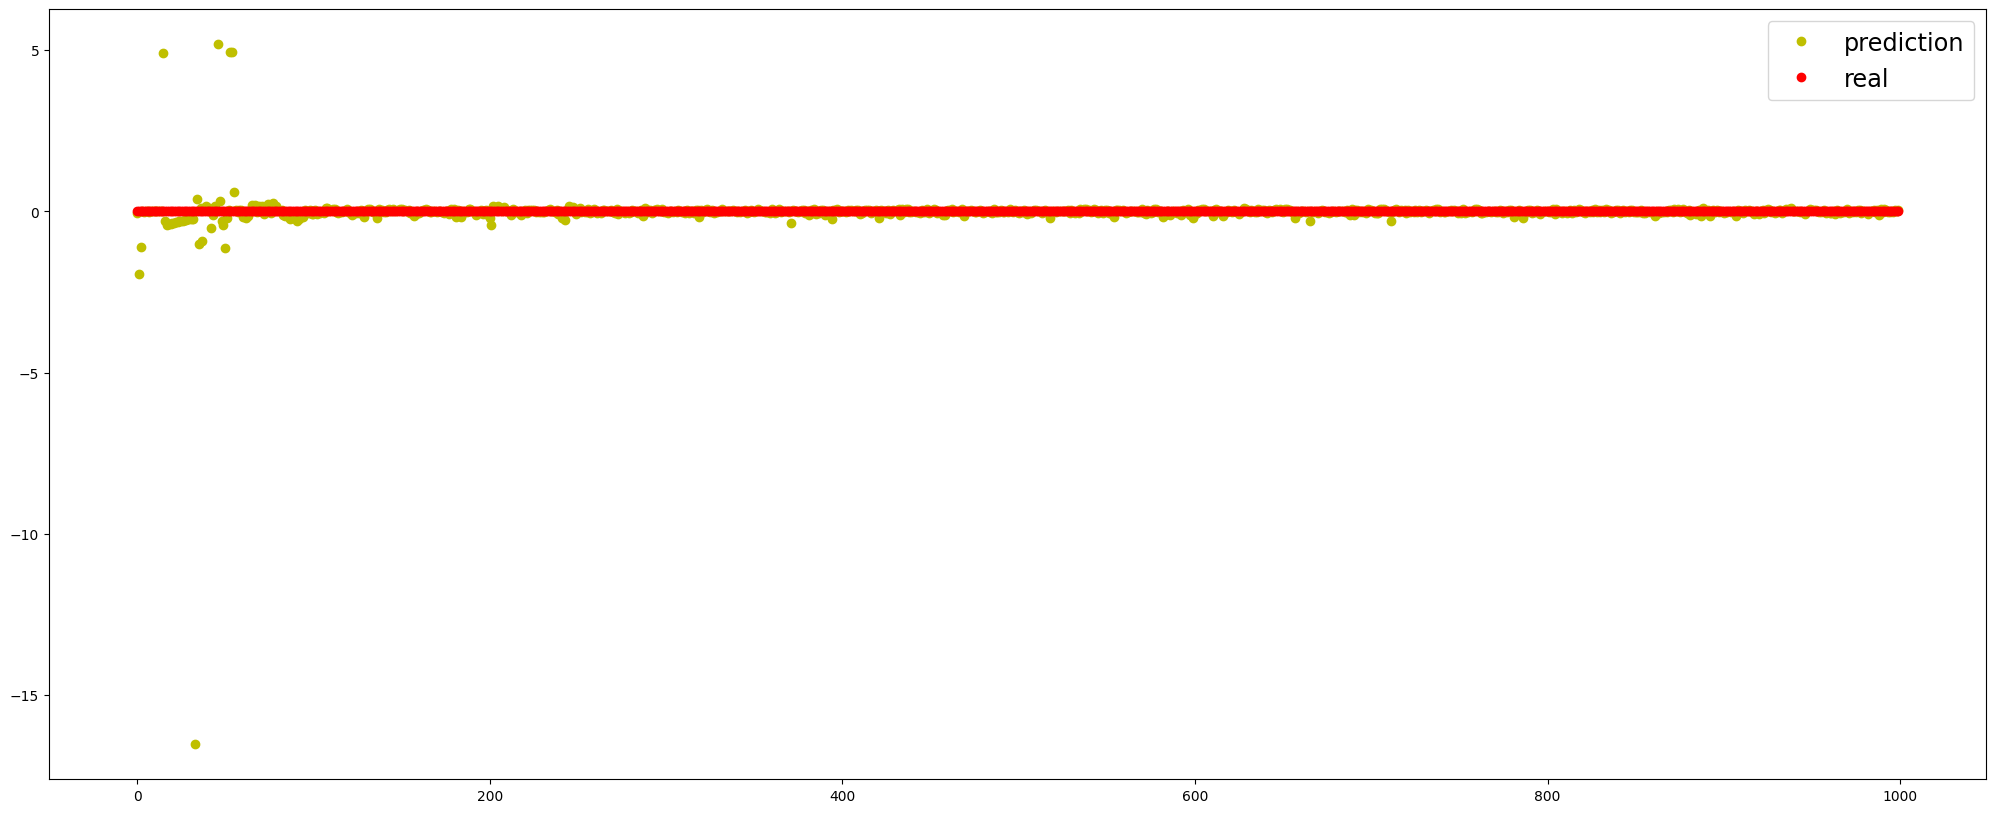

In [39]:
pred  =  predictServer("SES",bufferlen=50)
plotDifferencepredictions(pred,np.zeros(len(pred)))

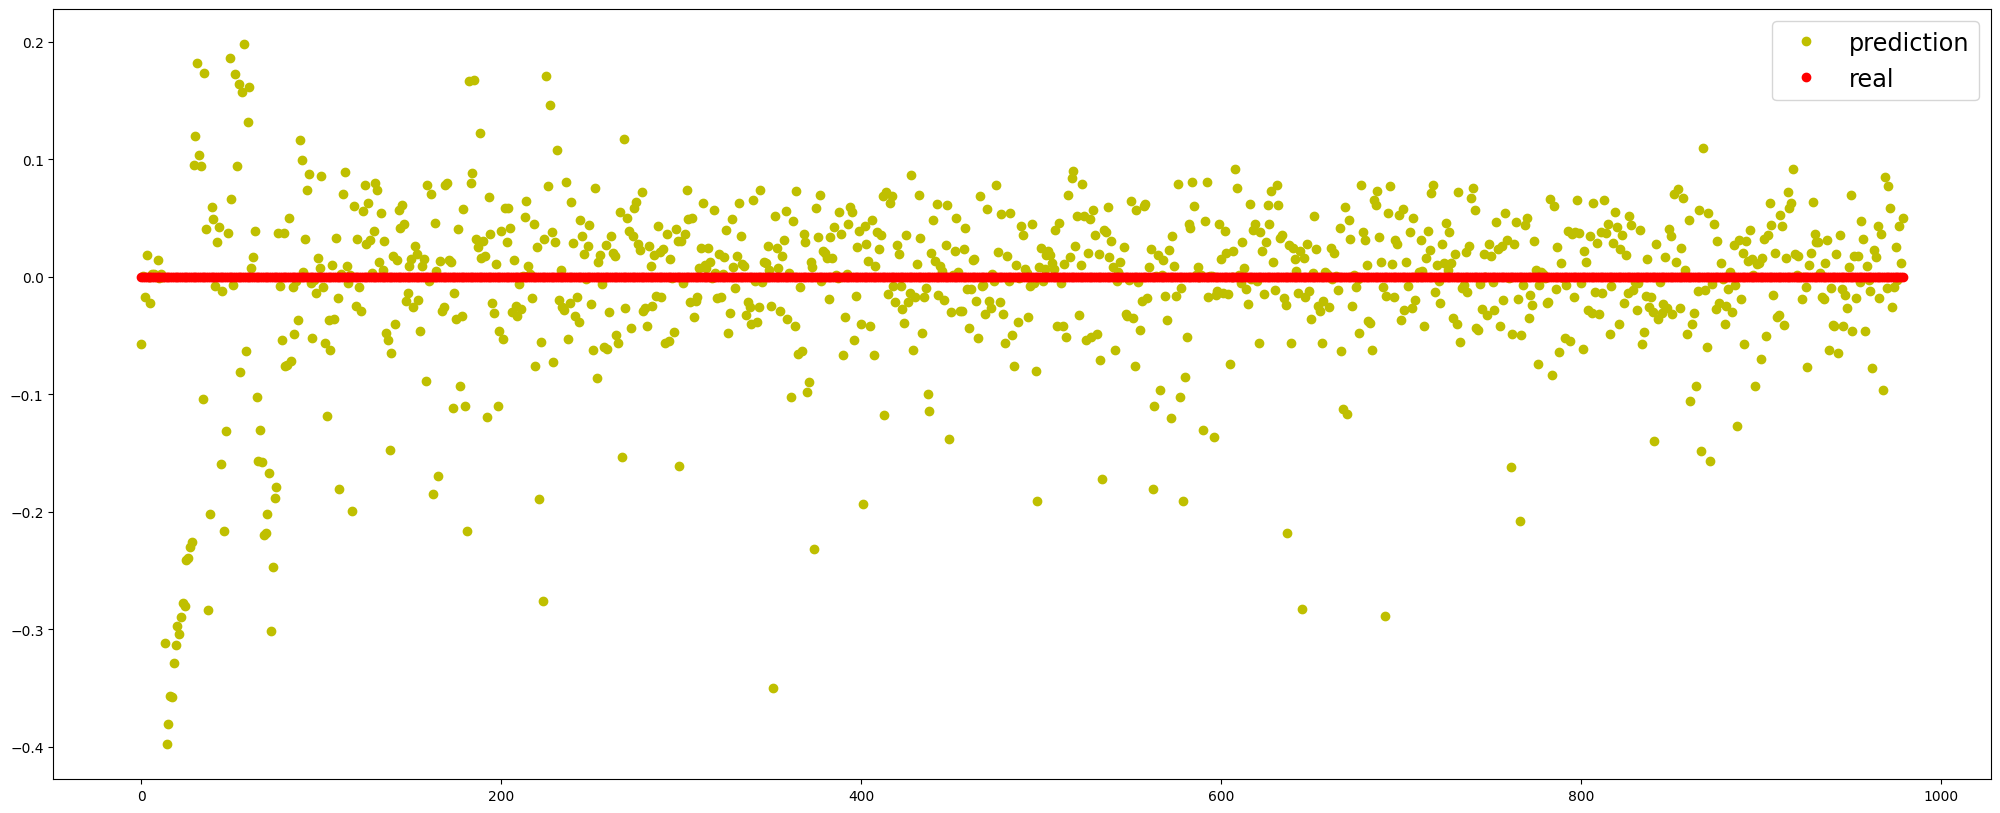

In [40]:
lowerb, upperbound =  np.percentile(pred,[1,99])
perclist = [x for x in pred if lowerb < x <  upperbound]

plotDifferencepredictions(perclist,np.zeros(len(perclist)))

In [41]:
calculateStatistics(pred)

        load back mem                       predicted                            CURRENT
               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|
    7                         450                              536                          5
accuracy= 0.986


0.986

Holt

there are 451 underEstimates with mean 0.03141813026607539 
there are 549 overEstimates with mean 0.09178477595628415
total mean absolute pinball score 0.06455941874999999


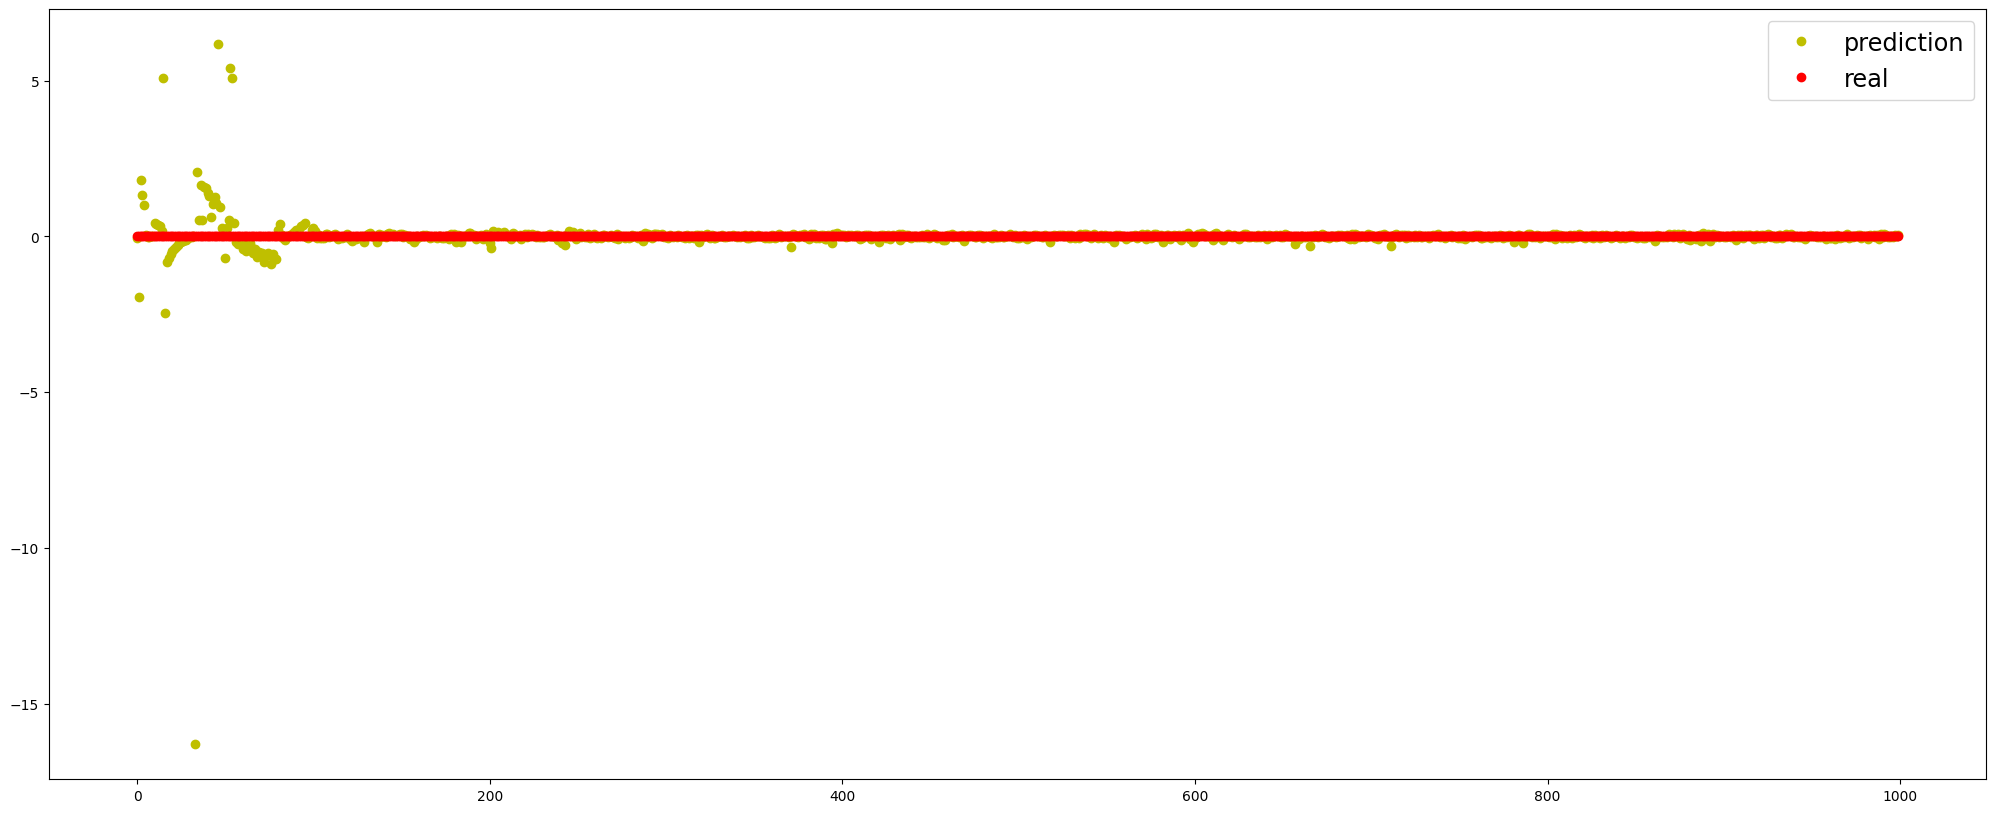

In [42]:
pred  =  predictServer("Holt",bufferlen=50)
plotDifferencepredictions(pred,np.zeros(len(pred)))

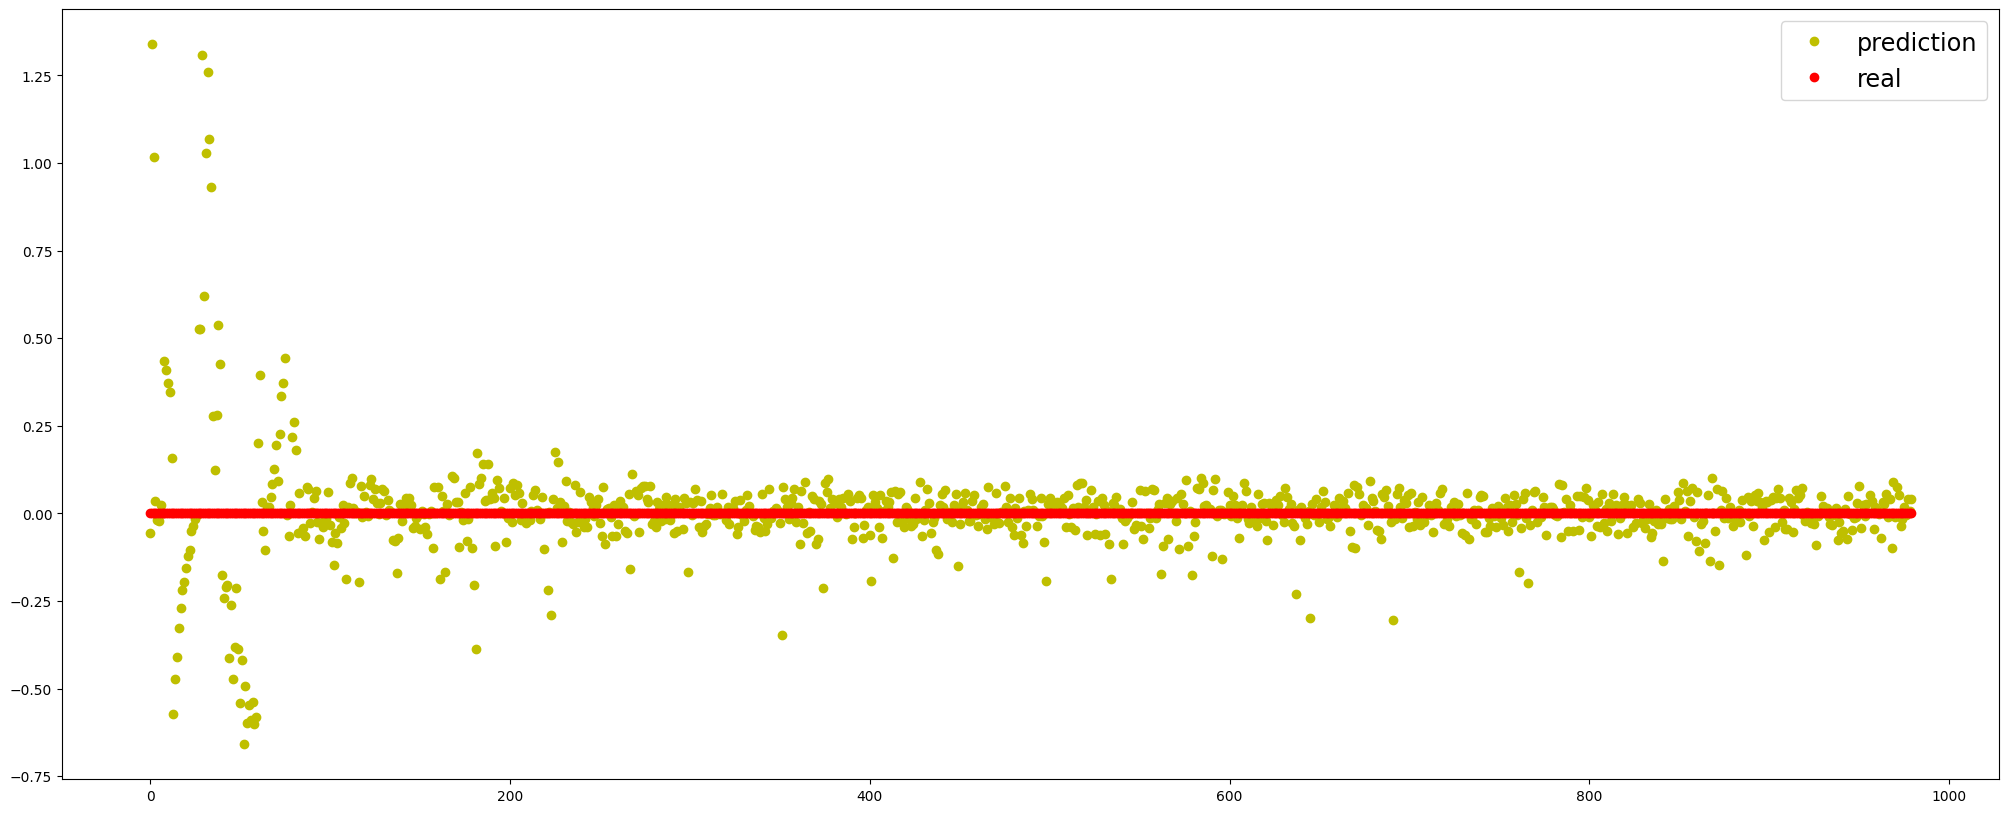

In [43]:
lowerb, upperbound =  np.percentile(pred,[1,99])
perclist = [x for x in pred if lowerb < x <  upperbound]

plotDifferencepredictions(perclist,np.zeros(len(perclist)))

In [44]:
calculateStatistics(pred)

        load back mem                       predicted                            CURRENT
               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|
    19                         431                              528                          21
accuracy= 0.959


0.959

winter

there are 459 underEstimates with mean 0.02777040413943355 
there are 541 overEstimates with mean 0.05934479390018484
total mean absolute pinball score 0.044852148999999994


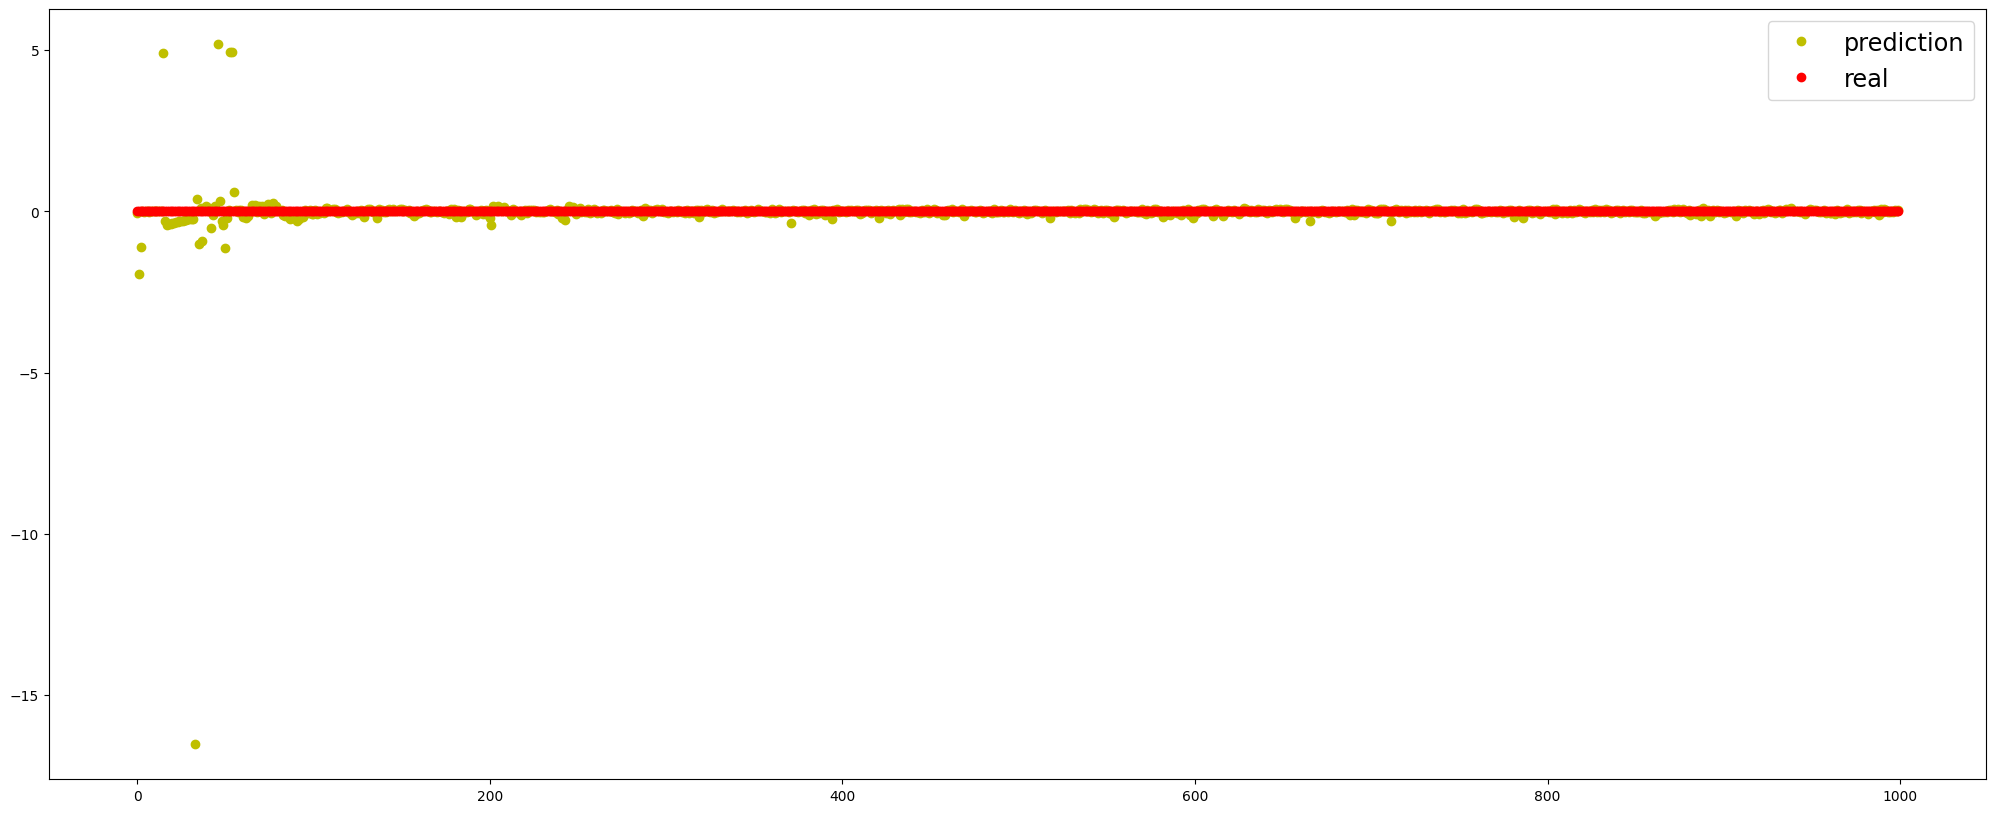

In [48]:
pred  =  predictServer("Winter",bufferlen=50)
plotDifferencepredictions(pred,np.zeros(len(pred)))

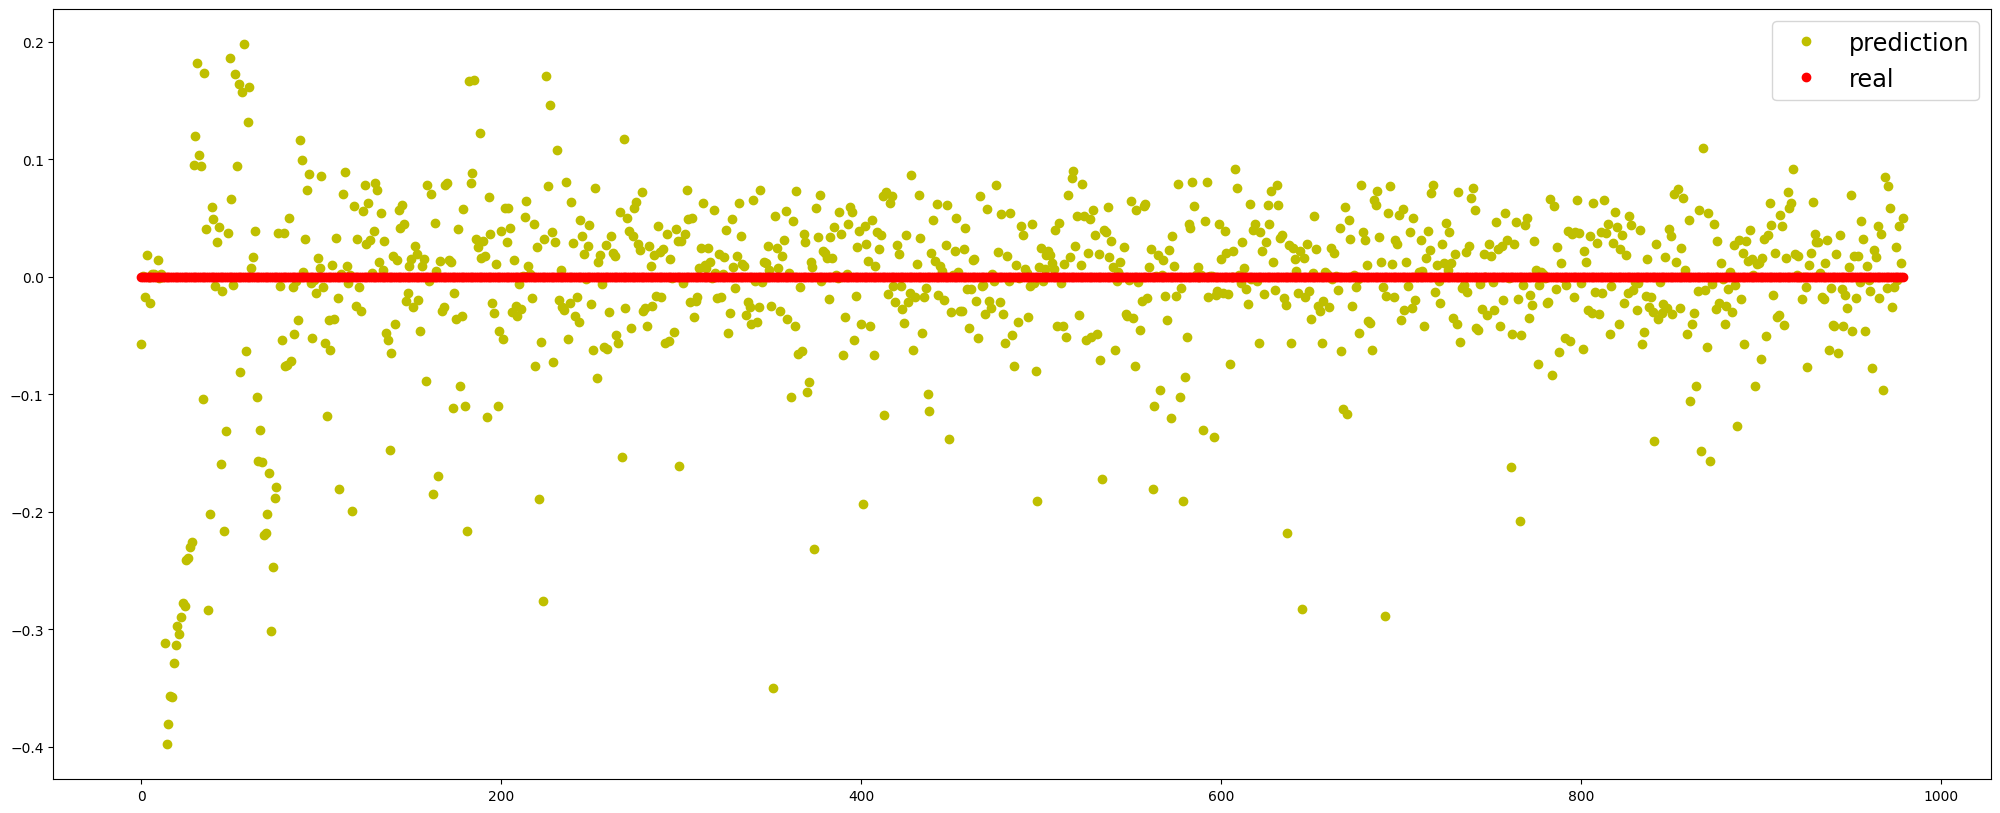

In [46]:
lowerb, upperbound =  np.percentile(pred,[1,99])
perclist = [x for x in pred if lowerb < x <  upperbound]

plotDifferencepredictions(perclist,np.zeros(len(perclist)))

In [47]:
calculateStatistics(pred)

        load back mem                       predicted                            CURRENT
               | ____TIMEBEFOREPREDICTEDMs________|_________GRACEPERIODMs________|
    7                         450                              536                          5
accuracy= 0.986


0.986

In [11]:
n_steps  = 20
n_features = 1
def perdictserverLSTM(diff_df):

    endtrain  =  int(len(diff_df) * 0.8)
    startTestIndex = endtrain
    endtestIndex =  len(diff_df)-1

    train_data = diff_df["sec"][:endtrain]
    test_data = diff_df["sec"][endtrain:]

    X,y = splitSequence(train_data,n_steps)


    model = tf.keras.Sequential()
    model.add(layers.LSTM(30,return_sequences=True ,activation='relu', input_shape=(n_steps, n_features)))
    model.add(layers.LSTM(units=10, return_sequences=True))
    model.add(layers.LSTM(units=10))
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tfa.losses.PinballLoss(tau=.25), metrics=['mean_absolute_error'])
    model.fit(X, y, epochs=200, verbose=1)


    pred = []
    for i in range(startTestIndex,len(diff_df)):

        hist = np.array(diff_df["sec"][i-n_steps:i]).reshape((1, n_steps, n_features))
        predict = model.predict(hist, verbose=1)
        preddiff = predict[0][0] - diff_df["sec"][i]
        pred.append(preddiff)
    return pred



Relationship  between length of startup  and  grace interval and the accurcay

In [12]:
predAutoreg  =  predictServer("autoReg",df,bufferlen=50)
predArima  =  predictServer("ARIMA",df,bufferlen=50)
predSES  =  predictServer("SES",df, bufferlen=50)
predHolt  =  predictServer("Holt",df, bufferlen=50)
#predWinter  =  predictServer("Winter",bufferlen=50)

In [13]:
predLstm  = perdictserverLSTM(diff_df)

2023-05-08 10:47:04.116811: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-08 10:47:04.122651: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-08 10:47:04.122755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kevin-GE72-2QE): /proc/driver/nvidia/version does not exist
2023-05-08 10:47:04.150146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
25/25 [==============================] - 7s 17ms/step - loss: 0.6386 - mean_absolute_error: 2.5297
Epoch 2/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0742 - mean_absolute_error: 0.1915
Epoch 3/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0410 - mean_absolute_error: 0.1139
Epoch 4/200
25/25 [==============================] - 1s 22ms/step - loss: 0.0379 - mean_absolute_error: 0.1013
Epoch 5/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0381 - mean_absolute_error: 0.1007
Epoch 6/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0387 - mean_absolute_error: 0.1044
Epoch 7/200
25/25 [==============================] - 0s 19ms/step - loss: 0.0379 - mean_absolute_error: 0.1003
Epoch 8/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0382 - mean_absolute_error: 0.1019
Epoch 9/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0388 - mean_absolute_error: 0.1029
E

In [14]:
metrics = {
    "reg" : [],
    "arima" :  [],
    "ses" : [],
    "holt":[],
    "winter":[],
    "lstm":[]

}
xvalues = list(range(200,-1,-1))
for i in xvalues:

    metrics["reg"].append( calculateStatistics(predAutoreg,TIMEBEFOREPREDICTEDMs=i/1000,GRACEPERIODMs=i/1000,debug=False))
    metrics["arima"].append(calculateStatistics(predArima,TIMEBEFOREPREDICTEDMs=i/1000,GRACEPERIODMs=i/1000,debug=False))
    metrics["ses"].append(calculateStatistics(predSES,TIMEBEFOREPREDICTEDMs=i/1000,GRACEPERIODMs=i/1000,debug=False))
    metrics["holt"].append(calculateStatistics(predHolt,TIMEBEFOREPREDICTEDMs=i/1000,GRACEPERIODMs=i/1000,debug=False))
    #metrics["winter"].append(calculateStatistics(predWinter,TIMEBEFOREPREDICTEDMs=i/1000,GRACEPERIODMs=i/1000,debug=False))
    metrics["lstm"].append(calculateStatistics(predLstm,TIMEBEFOREPREDICTEDMs=i/1000,GRACEPERIODMs=i/1000,debug=False))

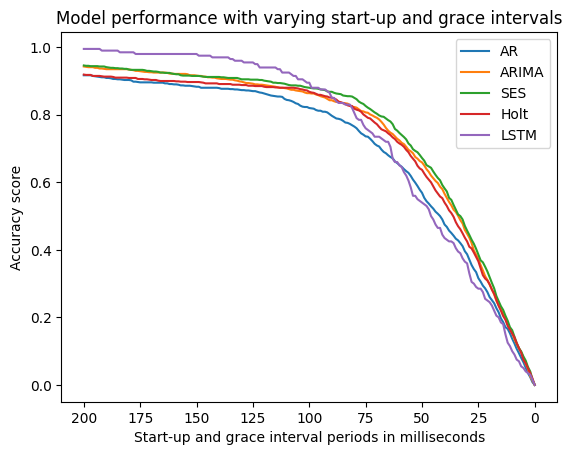

In [15]:
plt.title("Model performance with varying start-up and grace intervals")
plt.ylabel("Accuracy score")
plt.xlabel("Start-up and grace interval periods in milliseconds")
plt.plot(xvalues,metrics["reg"],label = "AR")
plt.plot(xvalues,metrics["arima"],label = "ARIMA")
plt.plot(xvalues,metrics["ses"],label = "SES")
plt.plot(xvalues,metrics["holt"],label = "Holt")
#plt.plot(xvalues,metrics["winter"],label = "Winter")
plt.plot(xvalues,metrics["lstm"],label = "LSTM")
ax = plt.gca()
ax.invert_xaxis()
plt.legend()
plt.show()





relation between buffer len  and  accuracy

In [17]:

metrics = {
    "reg" : [],
    "arima" :  [],
    "ses" : [],
    "holt":[],
    "winter":[],
    "lstm":[]

}
xvalues = list(range(25,70,5))
for i in xvalues:
    print(i)


    predAutoreg  =  predictServer("autoReg",df,bufferlen=i)
    predArima  =  predictServer("ARIMA",df,bufferlen=i)
    predSES  =  predictServer("SES",df,bufferlen=i)
    predHolt  =  predictServer("Holt",df,bufferlen=i)
    #predWinter  =  predictServer("Winter",bufferlen=i)

    metrics["reg"].append( calculateStatistics(predAutoreg,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["arima"].append(calculateStatistics(predArima,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["ses"].append(calculateStatistics(predSES,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["holt"].append(calculateStatistics(predHolt,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    #metrics["winter"].append(calculateStatistics(predWinter,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    






25
30
35
40
45
50
55
60
65


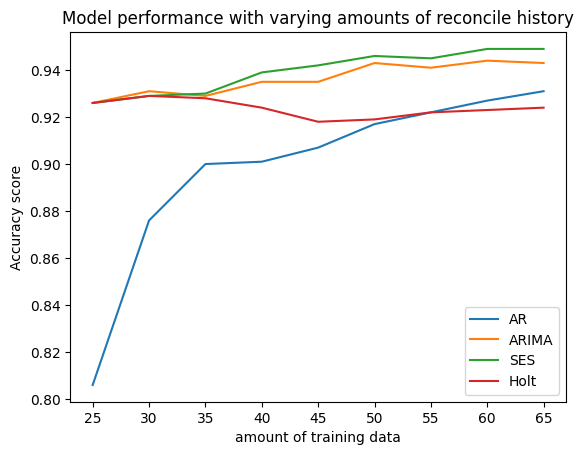

In [19]:
plt.title("Model performance with varying amounts of reconcile history")
plt.ylabel("Accuracy score")
plt.xlabel("amount of training data")
plt.plot(xvalues,metrics["reg"],label = "AR")
plt.plot(xvalues,metrics["arima"],label = "ARIMA")
plt.plot(xvalues,metrics["ses"],label = "SES")
plt.plot(xvalues,metrics["holt"],label = "Holt")
#plt.plot(xvalues,metrics["winter"],label = "Winter")
#plt.plot(xvalues,metrics["lstm"],label = "LSTM")
ax = plt.gca()
#ax.invert_xaxis()
plt.legend()
plt.show()


#model performance with   varying time intervals, just  add to it,  this way  noise is  still present

In [ ]:

metrics = {
    "reg" : [],
    "arima" :  [],
    "ses" : [],
    "holt":[],
    "winter":[],
    "lstm":[]

}
xvalues = list(range(5,65,5))
for i in xvalues:

    diffAdded = [x  + timedelta(seconds=i) for x in  diff]
    dfAdded = df.copy(deep=True)
    for t in  range(len(diffAdded)):
        dfAdded["reconsile_dates"][t+1] = dfAdded["reconsile_dates"][t]+ diffAdded[t]
    diff_dfAdded = pd.DataFrame({"diff": diffAdded, "sec": [x.total_seconds() for x in diffAdded]}) 
    print(i)

    predAutoreg  =  predictServer("autoReg",dfAdded,bufferlen=50)
    predArima  =  predictServer("ARIMA",dfAdded,bufferlen=50)
    predSES  =  predictServer("SES",dfAdded,bufferlen=50)
    predHolt  =  predictServer("Holt",dfAdded,bufferlen=50)
    #predWinter  =  predictServer("Winter",dfAdded,bufferlen=50)
    predLstm  = perdictserverLSTM(diff_dfAdded)

    metrics["reg"].append( calculateStatistics(predAutoreg,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["arima"].append(calculateStatistics(predArima,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["ses"].append(calculateStatistics(predSES,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["holt"].append(calculateStatistics(predHolt,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    #metrics["winter"].append(calculateStatistics(predWinter,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    metrics["lstm"].append(calculateStatistics(predLstm,TIMEBEFOREPREDICTEDMs=0.2,GRACEPERIODMs=0.2,debug=False))
    


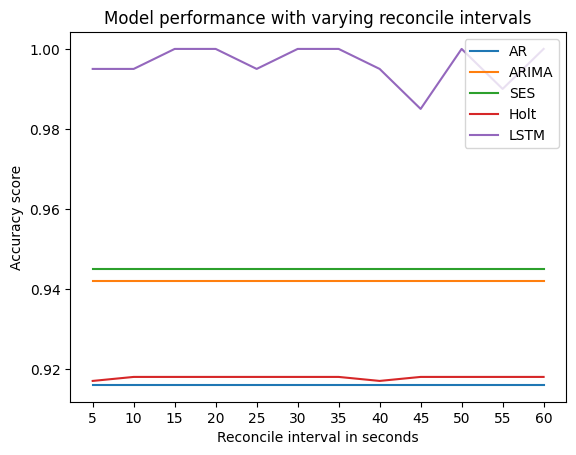

In [21]:
plt.title("Model performance with varying reconcile intervals")
plt.ylabel("Accuracy score")
plt.xlabel("Reconcile interval in seconds")
plt.plot(xvalues,metrics["reg"],label = "AR")
plt.plot(xvalues,metrics["arima"],label = "ARIMA")
plt.plot(xvalues,metrics["ses"],label = "SES")
plt.plot(xvalues,metrics["holt"],label = "Holt")
#plt.plot(xvalues,metrics["winter"],label = "Winter")
plt.plot(xvalues,metrics["lstm"],label = "LSTM")
plt.xticks(xvalues, xvalues)
plt.legend()
plt.show()

